# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
# Imports of all used packages and libraries
import sys
import os
import git
import glob
from collections import defaultdict

In [2]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [3]:
git_root

'/blue/npadillacoreano/ryoi360/projects/reward_comp/repos/reward_competition_extention'

In [4]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [7]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu


In [8]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [11]:
import utilities.helper
import trodes.read_exported

In [12]:
FONTSIZE = 20

In [13]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

## Inputs & Data

Explanation of each input and where it comes from.

In [14]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [15]:
TRIAL_LABELS_DF = pd.read_excel("./proc/rce2_finalized_trial_labels.xlsx")

In [16]:
LFP_SPECTRAL_DF = pd.read_pickle("../2024_01_30_rce2_spectral_preprocessing/proc/rce_pilot_2_02_full_spectral.pkl")

In [17]:
# CHANNEL_MAP_AND_ALL_TRIALS_DF = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")
# MERGED_TRIALS_AND_VIDEO = pd.read_pickle("./proc/trial_SLEAP_and_metadata.pkl")

In [18]:
OUTCOME_TO_COLOR = {'lose': "red",
 'omission': "orange",
 'rewarded': "green",
 'win': "blue"}

OUTCOME_TO_COLOR = {'lose': "#951a1d",
 'omission': "#af780d",
 'rewarded': "#0499af",
 'win': "#3853a3",
'lose_comp': "#951a1d",
 'win_comp': "#3853a3",
'lose_non_comp': "#e67073",
 'win_non_comp': "#93a5da"}

In [19]:
OUTCOME_COMPARISONS = {"win_lose": ("win", "lose"), "lose_omission": ("lose", "omission"), "win_rewarded": ("win", "rewarded")}

In [20]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [21]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [22]:
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5 to 10 cm/s", 3: "10cm/s+"}

In [23]:
MIN_VELOCITY = 0
MAX_VELOCITY = 2.5

In [24]:
MIN_DISTANCE = 0
MAX_DISTANCE = 5

In [25]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 6, "high_freq": 11}, "beta": {"low_freq": 20, "high_freq": 31}, "gamma": {"low_freq": 30, "high_freq": 51}}
BAND_TO_FREQ = {"theta": (6,11), "beta": (20,31), "gamma": (30,51)}

In [26]:
BAND_TO_YLIM = {"theta": 0.065,
"beta": 0.007,
"gamma": 0.005}

In [27]:
BRAIN_REGIONS = ["mPFC",
"vHPC",
"BLA",
"LH",
"MD"]

In [28]:
NUMBER_OF_COMPARISONS = 3

In [29]:
GROUPINGS = "trial_outcome"
# GROUPINGS = "competition_closeness"

In [30]:
FONTSIZE=20

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [31]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [32]:
def nested_dict():
    return defaultdict(dict)

In [33]:
def mean_of_counter(counter):
    # Extract values from the Counter and calculate the mean
    values = list(counter.values())
    return sum(values) / len(values) if values else 0  # Prevent division by zero

In [34]:
def adjust_lightness(color, amount=0.5):
    """
    Adjusts the lightness of the given color by the provided amount.
    :param color: Input color in some format that matplotlib's `to_rgb` can handle.
    :param amount: Amount to adjust. > 1 for lighter, < 1 for darker.
    :return: Adjusted color.
    """
    import colorsys
    c = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(*c)
    return colorsys.hls_to_rgb(h, max(0, min(1, amount * l)), s)

In [35]:
def generate_gradient_colors(base_color, num_colors=10):
    """
    Generate gradient colors based on a base color.
    
    :param base_color: The base color to create a gradient from.
    :param num_colors: The number of gradient colors to generate.
    :return: List of colors.
    """
    # Convert base color to HLS (Hue, Lightness, Saturation)
    h, l, s = colorsys.rgb_to_hls(*mcolors.to_rgb(base_color))

    # Determine the step size for lightness
    middle_index = num_colors // 2
    lightness_step = l / (middle_index if middle_index > 0 else 1)

    colors = []
    for i in range(num_colors):
        if i < middle_index:
            # For the lighter colors (before the middle)
            new_lightness = l + (middle_index - i) * lightness_step
        elif i == middle_index:
            # The middle color remains the base color
            new_lightness = l
        else:
            # For the darker colors (after the middle)
            new_lightness = l - (i - middle_index) * lightness_step

        # Ensure new lightness is within the valid range [0, 1]
        new_lightness = max(0, min(new_lightness, 1))

        new_color = colorsys.hls_to_rgb(h, new_lightness, s)
        colors.append(new_color)

    return colors

In [36]:
def get_significance_stars_from_p_value(p_value, number_of_comparisons=3):
    """
    """
    if p_value <= 0.001 / number_of_comparisons:
        return "***"
    elif p_value <= 0.01 / number_of_comparisons:
        return "***"
    elif p_value <= 0.05 / number_of_comparisons:
        return "*"
    else:
        return ""

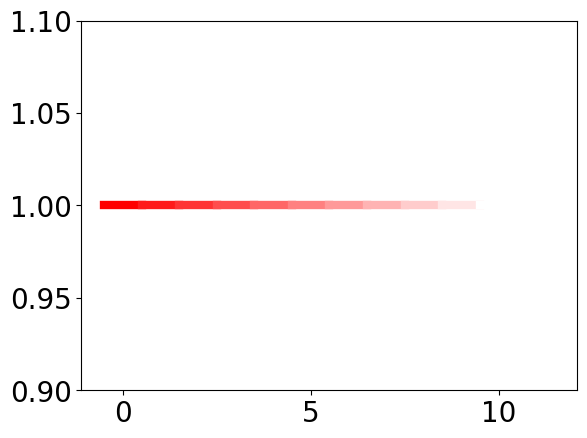

In [37]:
# Original color
original_color = 'red'  # Can be any color matplotlib understands

# Generate lighter versions
lighter_colors = [adjust_lightness(original_color, amount=1+(0.1*i)) for i in range(12)]

# Plotting to demonstrate the colors
for i, color in enumerate(lighter_colors):
    plt.plot([i-0.5, i+0.5], [1, 1], color=color, linewidth=6)  

plt.ylim(0.9, 1.1)
plt.show()

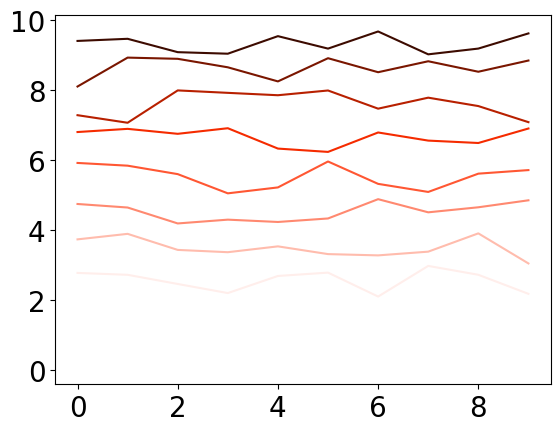

In [38]:
# Base color
base_color = '#ff5733'  # Reddish color

# Number of colors you want in the gradient
num_colors = 10

# Generate gradient colors
gradient_colors = generate_gradient_colors(base_color, num_colors)

# Set the color cycle to use the gradient colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=gradient_colors)

# Test by plotting some data
for i in range(num_colors):
    plt.plot(np.arange(10), np.random.rand(10) + i)

plt.show()

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [39]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




In [40]:
LFP_SPECTRAL_DF.columns

Index(['cohort', 'session_dir', 'tone_frames', 'box_1_port_entry_frames',
       'box_2_port_entry_frames', 'video_name', 'session_path', 'recording',
       'current_subject', 'subject', 'all_subjects', 'first_timestamp',
       'last_timestamp', 'video_timestamps', 'tone_timestamps',
       'box_1_port_entry_timestamps', 'box_2_port_entry_timestamps',
       'lfp_timestamps', 'mPFC_lfp_trace', 'MD_lfp_trace', 'LH_lfp_trace',
       'BLA_lfp_trace', 'vHPC_lfp_trace',
       'mPFC_power_all_frequencies_all_windows',
       'MD_power_all_frequencies_all_windows',
       'LH_power_all_frequencies_all_windows',
       'BLA_power_all_frequencies_all_windows',
       'vHPC_power_all_frequencies_all_windows', 'power_timestamps',
       'power_calculation_frequencies',
       'BLA_LH_coherence_all_frequencies_all_windows',
       'BLA_MD_coherence_all_frequencies_all_windows',
       'BLA_mPFC_coherence_all_frequencies_all_windows',
       'BLA_vHPC_coherence_all_frequencies_all_windows',
   

In [41]:
TRIAL_LABELS_DF.columns

Index(['tracked_subject', 'box_number', 'sleap_name', 'video_name',
       'current_subject', 'tone_start_frame', 'reward_start_frame',
       'tone_stop_frame', 'condition', 'competition_closeness', 'notes',
       'experiment', 'session_dir', 'all_subjects', 'tone_start_timestamp',
       'tone_stop_timestamp', 'trial_label'],
      dtype='object')

## Merging the labels and LFP spectral

In [42]:
TRIAL_LABELS_DF.head()

tracked_subject  box_number  \
0         1.1_1.2           1   
1         1.1_1.2           1   
2         1.1_1.2           1   
3         1.1_1.2           1   
4         1.1_1.2           1   

                                          sleap_name  \
0  20230612_112630_standard_comp_to_training_D1_s...   
1  20230612_112630_standard_comp_to_training_D1_s...   
2  20230612_112630_standard_comp_to_training_D1_s...   
3  20230612_112630_standard_comp_to_training_D1_s...   
4  20230612_112630_standard_comp_to_training_D1_s...   

                                          video_name  current_subject  \
0  20230612_112630_standard_comp_to_training_D1_s...              1.1   
1  20230612_112630_standard_comp_to_training_D1_s...              1.2   
2  20230612_112630_standard_comp_to_training_D1_s...              1.1   
3  20230612_112630_standard_comp_to_training_D1_s...              1.2   
4  20230612_112630_standard_comp_to_training_D1_s...              1.1   

   tone_start_frame  reward_start_frame  tone_stop_frame condition  \
0              1125                1225             1324       1.1   
1              1125                1225             1324       1.1   
2              3519                3619             3720       1.2   
3              3519                3619             3720       1.2   
4              5815                5915             6014       1.2   

    competition_closeness notes experiment  \
0  Subj 1 blocking Subj 2   NaN   standard   
1  Subj 1 blocking Subj 2   NaN   standard   
2             Subj 2 Only   NaN   standard   
3             Subj 2 Only   NaN   standard   
4  Subj 2 blocking Subj 1   NaN   standard   

                                         session_dir    all_subjects  \
0  20230612_112630_standard_comp_to_training_D1_s...  ['1.1', '1.2']   
1  20230612_112630_standard_comp_to_training_D1_s...  ['1.1', '1.2']   
2  20230612_112630_standard_comp_to_training_D1_s...  ['1.1', '1.2']   
3  20230612_112630_standard_comp_to_training_D1_s...  ['1.1', '1.2']   
4  20230612_112630_standard_comp_to_training_D1_s...  ['1.1', '1.2']   

   tone_start_timestamp  tone_stop_timestamp trial_label  
0               1126742              1326741         win  
1               1126742              1326741        lose  
2               3526740              3726740        lose  
3               3526740              3726740         win  
4               5826740              6026737        lose

In [43]:
LFP_SPECTRAL_DF.head()

cohort                                        session_dir  \
0       2  20230612_101430_standard_comp_to_training_D1_s...   
1       2  20230612_101430_standard_comp_to_training_D1_s...   
2       2  20230612_101430_standard_comp_to_training_D1_s...   
3       2  20230612_101430_standard_comp_to_training_D1_s...   
4       2  20230612_112630_standard_comp_to_training_D1_s...   

                                         tone_frames  \
0  [[980, 1181], [3376, 3575], [5672, 5871], [746...   
1  [[980, 1180], [3376, 3575], [5672, 5871], [746...   
2  [[980, 1181], [3376, 3575], [5672, 5871], [746...   
3  [[980, 1180], [3376, 3575], [5672, 5871], [746...   
4  [[1125, 1324], [3519, 3720], [5815, 6014], [76...   

                             box_1_port_entry_frames  \
0  [[490, 514], [518, 558], [558, 637], [638, 640...   
1  [[490, 514], [518, 558], [558, 637], [638, 640...   
2  [[490, 514], [518, 558], [558, 637], [638, 640...   
3  [[490, 514], [518, 558], [558, 637], [638, 640...   
4  [[192, 248], [389, 405], [916, 929], [929, 948...   

                             box_2_port_entry_frames  \
0  [[33137, 33147], [33665, 33666], [33668, 33669...   
1  [[33021, 33027], [33502, 33503], [33504, 33506...   
2  [[33137, 33147], [33665, 33666], [33668, 33669...   
3  [[33021, 33027], [33502, 33503], [33504, 33506...   
4  [[33019, 33020], [33246, 33251], [33253, 33255...   

                                          video_name  \
0  20230612_101430_standard_comp_to_training_D1_s...   
1  20230612_101430_standard_comp_to_training_D1_s...   
2  20230612_101430_standard_comp_to_training_D1_s...   
3  20230612_101430_standard_comp_to_training_D1_s...   
4  20230612_112630_standard_comp_to_training_D1_s...   

                                        session_path  \
0  /scratch/back_up/reward_competition_extention/...   
1  /scratch/back_up/reward_competition_extention/...   
2  /scratch/back_up/reward_competition_extention/...   
3  /scratch/back_up/reward_competition_extention/...   
4  /scratch/back_up/reward_competition_extention/...   

                                           recording current_subject subject  \
0  20230612_101430_standard_comp_to_training_D1_s...             1.3     1.3   
1  20230612_101430_standard_comp_to_training_D1_s...             1.3     1.3   
2  20230612_101430_standard_comp_to_training_D1_s...             1.4     1.4   
3  20230612_101430_standard_comp_to_training_D1_s...             1.4     1.4   
4  20230612_112630_standard_comp_to_training_D1_s...             1.1     1.1   

   ...        LH_vHPC_granger_all_frequencies_all_windows  \
0  ...  [[1.216, 0.633, 0.282, 0.613, 0.636, 1.501, 0....   
1  ...  [[1.216, 0.633, 0.282, 0.613, 0.636, 1.501, 0....   
2  ...  [[2.848, 1.116, 0.682, 0.198, 0.154, 0.127, 0....   
3  ...  [[2.848, 1.116, 0.682, 0.198, 0.154, 0.127, 0....   
4  ...  [[0.326, 0.1089, 0.624, 0.2566, 0.06903, 0.112...   

         vHPC_LH_granger_all_frequencies_all_windows  \
0  [[0.39, 0.2312, 0.02298, 0.1543, 0.315, 0.7856...   
1  [[0.39, 0.2312, 0.02298, 0.1543, 0.315, 0.7856...   
2  [[1.97, 1.198, 0.10645, 0.2512, 0.3628, 0.595,...   
3  [[1.97, 1.198, 0.10645, 0.2512, 0.3628, 0.595,...   
4  [[0.4377, 0.1589, 0.2129, 0.3435, 0.5723, 1.25...   

         MD_mPFC_granger_all_frequencies_all_windows  \
0  [[1.783, 1.615, 1.699, 0.9365, 1.126, 1.648, 0...   
1  [[1.783, 1.615, 1.699, 0.9365, 1.126, 1.648, 0...   
2  [[0.09326, 0.08734, 0.136, 0.0357, 0.1394, 0.2...   
3  [[0.09326, 0.08734, 0.136, 0.0357, 0.1394, 0.2...   
4  [[0.01956, 0.05756, 0.04272, 0.108, 0.4011, 1....   

         mPFC_MD_granger_all_frequencies_all_windows  \
0  [[1.663, 0.849, 1.167, 0.758, 0.328, 0.7144, 1...   
1  [[1.663, 0.849, 1.167, 0.758, 0.328, 0.7144, 1...   
2  [[1.11, 0.2117, 0.3718, 0.1334, 0.174, 0.7544,...   
3  [[1.11, 0.2117, 0.3718, 0.1334, 0.174, 0.7544,...   
4  [[0.1444, 0.5464, 0.3662, 0.3176, 0.2191, 0.08...   

         MD_vHPC_granger_all_frequencies_all_windows  \
0  [[2.055, 0.452,

In [44]:
LFP_SPECTRAL_DF["video_name"] = LFP_SPECTRAL_DF["video_name"].apply(lambda x: x.strip(".videoTimeStamps.cameraHWSync"))

In [45]:
LFP_SPECTRAL_DF["current_subject"] = LFP_SPECTRAL_DF["current_subject"].astype(str)
TRIAL_LABELS_DF["current_subject"] = TRIAL_LABELS_DF["current_subject"].astype(str)

In [46]:
LFP_SPECTRAL_DF["video_name"].unique()

array(['20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.1',
       '20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.2',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.2',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.2',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.2',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.3',
       '20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.1',
       '20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.2',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.2',
       '20230617_115521_standard_comp_

In [47]:
TRIAL_LABELS_DF["video_name"].iloc[0]

'20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1'

In [48]:
TRIALS_AND_SPECTRAL_DF = pd.merge(TRIAL_LABELS_DF, LFP_SPECTRAL_DF, on=["current_subject", "video_name"], how="inner")

In [49]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=[col for col in TRIALS_AND_SPECTRAL_DF.columns if "trace" in col], errors="ignore")

In [50]:
TRIALS_AND_SPECTRAL_DF.head()

tracked_subject  box_number  \
0         1.1_1.2           1   
1         1.1_1.2           1   
2         1.1_1.2           1   
3         1.1_1.2           1   
4         1.1_1.2           1   

                                          sleap_name  \
0  20230612_112630_standard_comp_to_training_D1_s...   
1  20230612_112630_standard_comp_to_training_D1_s...   
2  20230612_112630_standard_comp_to_training_D1_s...   
3  20230612_112630_standard_comp_to_training_D1_s...   
4  20230612_112630_standard_comp_to_training_D1_s...   

                                          video_name current_subject  \
0  20230612_112630_standard_comp_to_training_D1_s...             1.1   
1  20230612_112630_standard_comp_to_training_D1_s...             1.1   
2  20230612_112630_standard_comp_to_training_D1_s...             1.1   
3  20230612_112630_standard_comp_to_training_D1_s...             1.1   
4  20230612_112630_standard_comp_to_training_D1_s...             1.1   

   tone_start_frame  reward_start_frame  tone_stop_frame condition  \
0              1125                1225             1324       1.1   
1              3519                3619             3720       1.2   
2              5815                5915             6014       1.2   
3              7612                7712             7811       1.2   
4              8709                8809             8910       1.2   

    competition_closeness  ...  \
0  Subj 1 blocking Subj 2  ...   
1             Subj 2 Only  ...   
2  Subj 2 blocking Subj 1  ...   
3             Subj 2 Only  ...   
4             Subj 2 Only  ...   

         LH_vHPC_granger_all_frequencies_all_windows  \
0  [[0.326, 0.1089, 0.624, 0.2566, 0.06903, 0.112...   
1  [[0.326, 0.1089, 0.624, 0.2566, 0.06903, 0.112...   
2  [[0.326, 0.1089, 0.624, 0.2566, 0.06903, 0.112...   
3  [[0.326, 0.1089, 0.624, 0.2566, 0.06903, 0.112...   
4  [[0.326, 0.1089, 0.624, 0.2566, 0.06903, 0.112...   

         vHPC_LH_granger_all_frequencies_all_windows  \
0  [[0.4377, 0.1589, 0.2129, 0.3435, 0.5723, 1.25...   
1  [[0.4377, 0.1589, 0.2129, 0.3435, 0.5723, 1.25...   
2  [[0.4377, 0.1589, 0.2129, 0.3435, 0.5723, 1.25...   
3  [[0.4377, 0.1589, 0.2129, 0.3435, 0.5723, 1.25...   
4  [[0.4377, 0.1589, 0.2129, 0.3435, 0.5723, 1.25...   

         MD_mPFC_granger_all_frequencies_all_windows  \
0  [[0.01956, 0.05756, 0.04272, 0.108, 0.4011, 1....   
1  [[0.01956, 0.05756, 0.04272, 0.108, 0.4011, 1....   
2  [[0.01956, 0.05756, 0.04272, 0.108, 0.4011, 1....   
3  [[0.01956, 0.05756, 0.04272, 0.108, 0.4011, 1....   
4  [[0.01956, 0.05756, 0.04272, 0.108, 0.4011, 1....   

         mPFC_MD_granger_all_frequencies_all_windows  \
0  [[0.1444, 0.5464, 0.3662, 0.3176, 0.2191, 0.08...   
1  [[0.1444, 0.5464, 0.3662, 0.3176, 0.2191, 0.08...   
2  [[0.1444, 0.5464, 0.3662, 0.3176, 0.2191, 0.08...   
3  [[0.1444, 0.5464, 0.3662, 0.3176, 0.2191, 0.08...   
4  [[0.1444, 0.5464, 0.3662, 0.3176, 0.2191, 0.08...   

         MD_vHPC_granger_all_frequencies_all_windows  \
0  [[0.8516, 0.1353, 0.897, 0.2006, 0.02, 0.1517,...   
1  [[0.8516, 0.1353, 0.897, 0.2006, 0.02, 0.1517,...   
2  [[0.8516, 0.1353, 0.897, 0.2006, 0.02, 0.1517,...   
3  [[0.8516, 0.1353, 0.897, 0.2006, 0.02, 0.1517,...   
4  [[0.8516, 0.1353, 0.897, 0.2006, 0.02, 0.1517,...   

         vHPC_MD_granger_all_frequencies_all_windows  \
0  [[0.273, 0.1354, 0.1842, 0.1063, 0.9165, 0.894...   
1  [[0.273, 0.1354, 0.1842, 0.1063, 0.9165, 0.894...   
2  [[0.273, 0.1354, 0.1842, 0.1063, 0.9165, 0.894...   
3  [[0.273, 0.1354, 0.1842, 0.1063, 0.9165, 0.894...   
4  [[0.273, 0.1354, 0.1842, 0.1063, 0.9165, 0.894...   

       mPFC_vHPC_granger_all_frequencies_all_windows  \
0  [[0.1587, 0.256, 0.2253, 0.1144, 0.04657, 0.24...   
1  [[0.1587, 0.256, 0.2253, 0.1144, 0.04657, 0.24...   
2  [[0.1587, 0.256, 0.2253, 0.1144, 0.04657, 0.24...   
3  [[0.1587, 0.256, 0.2253, 0.1144, 0.04657, 0.24...   
4  [[0.1587, 0.256, 0.2253, 0.1144, 0.04657, 0.24...   

       vHPC_mPFC_granger_all_frequencies_all_win

In [51]:
TRIALS_AND_SPECTRAL_DF.columns

Index(['tracked_subject', 'box_number', 'sleap_name', 'video_name',
       'current_subject', 'tone_start_frame', 'reward_start_frame',
       'tone_stop_frame', 'condition', 'competition_closeness', 'notes',
       'experiment', 'session_dir_x', 'all_subjects_x', 'tone_start_timestamp',
       'tone_stop_timestamp', 'trial_label', 'cohort', 'session_dir_y',
       'tone_frames', 'box_1_port_entry_frames', 'box_2_port_entry_frames',
       'session_path', 'recording', 'subject', 'all_subjects_y',
       'first_timestamp', 'last_timestamp', 'video_timestamps',
       'tone_timestamps', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps', 'lfp_timestamps',
       'mPFC_power_all_frequencies_all_windows',
       'MD_power_all_frequencies_all_windows',
       'LH_power_all_frequencies_all_windows',
       'BLA_power_all_frequencies_all_windows',
       'vHPC_power_all_frequencies_all_windows', 'power_timestamps',
       'power_calculation_frequencies',
       'BLA_LH_cohere

In [52]:
TRIALS_AND_SPECTRAL_DF["baseline_start_timestamp"] = TRIALS_AND_SPECTRAL_DF["tone_start_timestamp"] - 10 * 20000

In [53]:
TRIALS_AND_SPECTRAL_DF["baseline_start_timestamp"].head()

0     926742
1    3326740
2    5626740
3    7426736
4    8526734
Name: baseline_start_timestamp, dtype: int64

In [54]:
TRIALS_AND_SPECTRAL_DF["tone_start_timestamp"].head()

0    1126742
1    3526740
2    5826740
3    7626736
4    8726734
Name: tone_start_timestamp, dtype: int64

In [55]:
TRIALS_AND_SPECTRAL_DF["tone_stop_timestamp"].head()

0    1326741
1    3726740
2    6026737
3    7826735
4    8926734
Name: tone_stop_timestamp, dtype: int64

- Filtering power

In [56]:
power_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "power_all_frequencies_all_windows" in col]

In [57]:
power_columns

['mPFC_power_all_frequencies_all_windows',
 'MD_power_all_frequencies_all_windows',
 'LH_power_all_frequencies_all_windows',
 'BLA_power_all_frequencies_all_windows',
 'vHPC_power_all_frequencies_all_windows']

In [58]:
for col in power_columns:
    brain_region = col.split("_")[0]
    updated_item_col = "baseline_power_{}".format(brain_region)
    updated_timestamp_col = "baseline_power_timestamps".format(brain_region)
    print(updated_item_col)
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["baseline_start_timestamp"], stop=x["tone_start_timestamp"], timestamps=x["power_timestamps"], items=x[col])[1], axis=1)
    TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["baseline_start_timestamp"], stop=x["tone_start_timestamp"], timestamps=x["power_timestamps"], items=x[col])[0], axis=1)

baseline_power_mPFC
baseline_power_MD
baseline_power_LH
baseline_power_BLA
baseline_power_vHPC


In [59]:
for col in power_columns:
    brain_region = col.split("_")[0]
    updated_item_col = "trial_power_{}".format(brain_region)
    updated_timestamp_col = "trial_power_timestamps".format(brain_region)
    print(updated_item_col)
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["power_timestamps"], items=x[col])[1], axis=1)
    TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["power_timestamps"], items=x[col])[0], axis=1)

trial_power_mPFC
trial_power_MD
trial_power_LH
trial_power_BLA
trial_power_vHPC


In [60]:
for col in power_columns:
    brain_region = col.split("_")[0]
    updated_item_col = "both_power_{}".format(brain_region)
    updated_timestamp_col = "both_power_timestamps"
    print(updated_item_col)
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["baseline_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["power_timestamps"], items=x[col])[1], axis=1)
    TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["baseline_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["power_timestamps"], items=x[col])[0], axis=1)

both_power_mPFC
both_power_MD
both_power_LH
both_power_BLA
both_power_vHPC


In [61]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=power_columns + ["power_timestamps"], errors="ignore")

- Filtering coherence

In [62]:
coherence_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "coherence_all_frequencies_all_windows" in col]

In [63]:
coherence_columns

['BLA_LH_coherence_all_frequencies_all_windows',
 'BLA_MD_coherence_all_frequencies_all_windows',
 'BLA_mPFC_coherence_all_frequencies_all_windows',
 'BLA_vHPC_coherence_all_frequencies_all_windows',
 'LH_MD_coherence_all_frequencies_all_windows',
 'LH_mPFC_coherence_all_frequencies_all_windows',
 'LH_vHPC_coherence_all_frequencies_all_windows',
 'MD_mPFC_coherence_all_frequencies_all_windows',
 'MD_vHPC_coherence_all_frequencies_all_windows',
 'mPFC_vHPC_coherence_all_frequencies_all_windows']

In [64]:
for col in coherence_columns:
    brain_region = "_".join(col.split("_")[:2])
    
    updated_item_col = "baseline_coherence_{}".format(brain_region)
    updated_timestamp_col = "baseline_coherence_timestamps".format(brain_region)
    print(updated_item_col)
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["baseline_start_timestamp"], stop=x["tone_start_timestamp"], timestamps=x["coherence_timestamps"], items=x[col])[1], axis=1)
    TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["baseline_start_timestamp"], stop=x["tone_start_timestamp"], timestamps=x["coherence_timestamps"], items=x[col])[0], axis=1)

baseline_coherence_BLA_LH
baseline_coherence_BLA_MD
baseline_coherence_BLA_mPFC
baseline_coherence_BLA_vHPC
baseline_coherence_LH_MD
baseline_coherence_LH_mPFC
baseline_coherence_LH_vHPC
baseline_coherence_MD_mPFC
baseline_coherence_MD_vHPC
baseline_coherence_mPFC_vHPC


In [65]:
for col in coherence_columns:
    brain_region = "_".join(col.split("_")[:2])
    
    updated_item_col = "trial_coherence_{}".format(brain_region)
    updated_timestamp_col = "trial_coherence_timestamps".format(brain_region)
    print(updated_item_col)
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["coherence_timestamps"], items=x[col])[1], axis=1)
    TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["coherence_timestamps"], items=x[col])[0], axis=1)

trial_coherence_BLA_LH
trial_coherence_BLA_MD
trial_coherence_BLA_mPFC
trial_coherence_BLA_vHPC
trial_coherence_LH_MD
trial_coherence_LH_mPFC
trial_coherence_LH_vHPC
trial_coherence_MD_mPFC
trial_coherence_MD_vHPC
trial_coherence_mPFC_vHPC


In [66]:
for col in coherence_columns:
    brain_region = "_".join(col.split("_")[:2])
    
    updated_item_col = "both_coherence_{}".format(brain_region)
    updated_timestamp_col = "both_coherence_timestamps".format(brain_region)
    print(updated_item_col)
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["baseline_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["coherence_timestamps"], items=x[col])[1], axis=1)
    TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["baseline_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["coherence_timestamps"], items=x[col])[0], axis=1)

both_coherence_BLA_LH
both_coherence_BLA_MD
both_coherence_BLA_mPFC
both_coherence_BLA_vHPC
both_coherence_LH_MD
both_coherence_LH_mPFC
both_coherence_LH_vHPC
both_coherence_MD_mPFC
both_coherence_MD_vHPC
both_coherence_mPFC_vHPC


In [67]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=coherence_columns + ["coherence_timestamps"], errors="ignore")

- Filtering Grangers

In [68]:
granger_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "granger_all_frequencies_all_windows" in col]

In [69]:
granger_columns

['BLA_LH_granger_all_frequencies_all_windows',
 'LH_BLA_granger_all_frequencies_all_windows',
 'BLA_MD_granger_all_frequencies_all_windows',
 'MD_BLA_granger_all_frequencies_all_windows',
 'BLA_mPFC_granger_all_frequencies_all_windows',
 'mPFC_BLA_granger_all_frequencies_all_windows',
 'BLA_vHPC_granger_all_frequencies_all_windows',
 'vHPC_BLA_granger_all_frequencies_all_windows',
 'LH_MD_granger_all_frequencies_all_windows',
 'MD_LH_granger_all_frequencies_all_windows',
 'LH_mPFC_granger_all_frequencies_all_windows',
 'mPFC_LH_granger_all_frequencies_all_windows',
 'LH_vHPC_granger_all_frequencies_all_windows',
 'vHPC_LH_granger_all_frequencies_all_windows',
 'MD_mPFC_granger_all_frequencies_all_windows',
 'mPFC_MD_granger_all_frequencies_all_windows',
 'MD_vHPC_granger_all_frequencies_all_windows',
 'vHPC_MD_granger_all_frequencies_all_windows',
 'mPFC_vHPC_granger_all_frequencies_all_windows',
 'vHPC_mPFC_granger_all_frequencies_all_windows']

In [70]:
for col in granger_columns:
    brain_region = "_".join(col.split("_")[:2])
    
    updated_item_col = "baseline_granger_{}".format(brain_region)
    updated_timestamp_col = "baseline_granger_timestamps".format(brain_region)
    print(updated_item_col)
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["baseline_start_timestamp"], stop=x["tone_start_timestamp"], timestamps=x["granger_timestamps"], items=x[col])[1], axis=1)
    TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["baseline_start_timestamp"], stop=x["tone_start_timestamp"], timestamps=x["granger_timestamps"], items=x[col])[0], axis=1)

baseline_granger_BLA_LH
baseline_granger_LH_BLA
baseline_granger_BLA_MD
baseline_granger_MD_BLA
baseline_granger_BLA_mPFC
baseline_granger_mPFC_BLA
baseline_granger_BLA_vHPC
baseline_granger_vHPC_BLA
baseline_granger_LH_MD
baseline_granger_MD_LH
baseline_granger_LH_mPFC
baseline_granger_mPFC_LH
baseline_granger_LH_vHPC
baseline_granger_vHPC_LH
baseline_granger_MD_mPFC
baseline_granger_mPFC_MD
baseline_granger_MD_vHPC
baseline_granger_vHPC_MD
baseline_granger_mPFC_vHPC
baseline_granger_vHPC_mPFC


In [71]:
for col in granger_columns:
    brain_region = "_".join(col.split("_")[:2])
    
    updated_item_col = "trial_granger_{}".format(brain_region)
    updated_timestamp_col = "trial_granger_timestamps".format(brain_region)
    print(updated_item_col)
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["granger_timestamps"], items=x[col])[1], axis=1)
    TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["granger_timestamps"], items=x[col])[0], axis=1)

trial_granger_BLA_LH
trial_granger_LH_BLA
trial_granger_BLA_MD
trial_granger_MD_BLA
trial_granger_BLA_mPFC
trial_granger_mPFC_BLA
trial_granger_BLA_vHPC
trial_granger_vHPC_BLA
trial_granger_LH_MD
trial_granger_MD_LH
trial_granger_LH_mPFC
trial_granger_mPFC_LH
trial_granger_LH_vHPC
trial_granger_vHPC_LH
trial_granger_MD_mPFC
trial_granger_mPFC_MD
trial_granger_MD_vHPC
trial_granger_vHPC_MD
trial_granger_mPFC_vHPC
trial_granger_vHPC_mPFC


In [72]:
for col in granger_columns:
    brain_region = "_".join(col.split("_")[:2])
    
    updated_item_col = "both_granger_{}".format(brain_region)
    updated_timestamp_col = "both_granger_timestamps".format(brain_region)
    print(updated_item_col)
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["baseline_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["granger_timestamps"], items=x[col])[1], axis=1)
    TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["baseline_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["granger_timestamps"], items=x[col])[0], axis=1)

both_granger_BLA_LH
both_granger_LH_BLA
both_granger_BLA_MD
both_granger_MD_BLA
both_granger_BLA_mPFC
both_granger_mPFC_BLA
both_granger_BLA_vHPC
both_granger_vHPC_BLA
both_granger_LH_MD
both_granger_MD_LH
both_granger_LH_mPFC
both_granger_mPFC_LH
both_granger_LH_vHPC
both_granger_vHPC_LH
both_granger_MD_mPFC
both_granger_mPFC_MD
both_granger_MD_vHPC
both_granger_vHPC_MD
both_granger_mPFC_vHPC
both_granger_vHPC_mPFC


In [73]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=granger_columns + ["granger_timestamps"], errors="ignore")

In [74]:
TRIALS_AND_SPECTRAL_DF.columns

Index(['tracked_subject', 'box_number', 'sleap_name', 'video_name',
       'current_subject', 'tone_start_frame', 'reward_start_frame',
       'tone_stop_frame', 'condition', 'competition_closeness',
       ...
       'both_granger_LH_mPFC', 'both_granger_mPFC_LH', 'both_granger_LH_vHPC',
       'both_granger_vHPC_LH', 'both_granger_MD_mPFC', 'both_granger_mPFC_MD',
       'both_granger_MD_vHPC', 'both_granger_vHPC_MD',
       'both_granger_mPFC_vHPC', 'both_granger_vHPC_mPFC'],
      dtype='object', length=151)

- Averaging across time

In [75]:
all_spectral_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "BLA" in col or "mPFC" in col or "MD" in col or "vHPC" in col or "LH" in col]

In [76]:
for col in all_spectral_columns:
    TRIALS_AND_SPECTRAL_DF["{}_averaged".format(col)] = TRIALS_AND_SPECTRAL_DF[col].apply(lambda x: np.nanmean(x, axis=0)[:101])

In [77]:
TRIALS_AND_SPECTRAL_DF.head()

tracked_subject  box_number  \
0         1.1_1.2           1   
1         1.1_1.2           1   
2         1.1_1.2           1   
3         1.1_1.2           1   
4         1.1_1.2           1   

                                          sleap_name  \
0  20230612_112630_standard_comp_to_training_D1_s...   
1  20230612_112630_standard_comp_to_training_D1_s...   
2  20230612_112630_standard_comp_to_training_D1_s...   
3  20230612_112630_standard_comp_to_training_D1_s...   
4  20230612_112630_standard_comp_to_training_D1_s...   

                                          video_name current_subject  \
0  20230612_112630_standard_comp_to_training_D1_s...             1.1   
1  20230612_112630_standard_comp_to_training_D1_s...             1.1   
2  20230612_112630_standard_comp_to_training_D1_s...             1.1   
3  20230612_112630_standard_comp_to_training_D1_s...             1.1   
4  20230612_112630_standard_comp_to_training_D1_s...             1.1   

   tone_start_frame  reward_start_frame  tone_stop_frame condition  \
0              1125                1225             1324       1.1   
1              3519                3619             3720       1.2   
2              5815                5915             6014       1.2   
3              7612                7712             7811       1.2   
4              8709                8809             8910       1.2   

    competition_closeness  ...  \
0  Subj 1 blocking Subj 2  ...   
1             Subj 2 Only  ...   
2  Subj 2 blocking Subj 1  ...   
3             Subj 2 Only  ...   
4             Subj 2 Only  ...   

                       both_granger_LH_mPFC_averaged  \
0  [0.9956, 0.5815, 0.4133, 0.4136, 0.4731, 0.465...   
1  [0.7744, 0.427, 0.3542, 0.4624, 0.4019, 0.4604...   
2  [0.5767, 0.4392, 0.2942, 0.4316, 0.389, 0.3833...   
3  [0.64, 0.452, 0.4648, 0.3706, 0.5757, 0.6724, ...   
4  [0.8066, 0.593, 0.4133, 0.3853, 0.4058, 0.3699...   

                       both_granger_mPFC_LH_averaged  \
0  [0.6504, 0.3657, 0.3706, 0.2393, 0.2742, 0.478...   
1  [0.6533, 0.3752, 0.311, 0.2666, 0.4421, 0.4048...   
2  [0.466, 0.356, 0.241, 0.3345, 0.3142, 0.3223, ...   
3  [0.6953, 0.4424, 0.2524, 0.271, 0.269, 0.4233,...   
4  [0.543, 0.4128, 0.2876, 0.317, 0.3862, 0.4507,...   

                       both_granger_LH_vHPC_averaged  \
0  [0.3743, 0.4458, 0.4993, 0.582, 0.5703, 0.622,...   
1  [0.5327, 0.4868, 0.4246, 0.4548, 0.5938, 0.493...   
2  [0.7803, 0.519, 0.3875, 0.4927, 0.4941, 0.647,...   
3  [0.957, 0.4949, 0.4285, 0.3306, 0.4668, 0.4739...   
4  [0.452, 0.3052, 0.2986, 0.3008, 0.2281, 0.308,...   

                       both_granger_vHPC_LH_averaged  \
0  [0.4644, 0.373, 0.2905, 0.153, 0.1536, 0.2383,...   
1  [0.693, 0.2805, 0.3274, 0.2266, 0.3284, 0.33, ...   
2  [0.6772, 0.3313, 0.3003, 0.2769, 0.1865, 0.368...   
3  [0.5986, 0.4238, 0.2344, 0.2308, 0.267, 0.4478...   
4  [0.7812, 0.526, 0.4082, 0.4062, 0.524, 0.4324,...   

                       both_granger_MD_mPFC_averaged  \
0  [0.761, 0.5825, 0.4243, 0.4563, 0.4993, 0.42, ...   
1  [0.537, 0.4712, 0.45, 0.4526, 0.4932, 0.737, 0...   
2  [0.4802, 0.3215, 0.2854, 0.4673, 0.4358, 0.411...   
3  [0.587, 0.559, 0.4382, 0.4878, 0.472, 0.5845, ...   
4  [0.881, 0.62, 0.558, 0.4497, 0.4167, 0.3691, 0...   

                       both_granger_mPFC_MD_averaged  \
0  [0.616, 0.3499, 0.4077, 0.3442, 0.436, 0.579, ...   
1  [0.6304, 0.3755, 0.3438, 0.2847, 0.4304, 0.403...   
2  [0.4736, 0.3127, 0.2236, 0.2908, 0.2262, 0.380...   
3  [0.6323, 0.4636, 0.317, 0.2737, 0.2722, 0.3447...   
4  [0.5747, 0.3247, 0.2507, 0.2712, 0.3616, 0.398...   

                       both_granger_MD_vHPC_averaged  \
0  [0.5527, 0.5674, 0.5127, 0.62, 0.571, 0.5684, ...   
1  [0.541, 0.4785, 0.4011, 0.4072, 0.482, 0.5474,...   
2  [0.742, 0.5625, 0.308, 0.582, 0.439, 0.5176, 0...   
3  [0.5737, 0.5083, 0.5317, 0.4226, 0.447, 0.5283...   
4  [0.5884, 0.2856, 0.4277, 0.403, 0.2827, 0.3135...   

                       both_granger_vHPC_MD_aver

## Filtering by theta and gamma band

In [78]:
theta_band = (4, 12)
gamma_band = (30, 80)

- Filtering theta/gamma for power

In [79]:
power_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "power" in col and "freq" not in col and "time" not in col and "averaged" not in col]

In [80]:
power_columns

['baseline_power_mPFC',
 'baseline_power_MD',
 'baseline_power_LH',
 'baseline_power_BLA',
 'baseline_power_vHPC',
 'trial_power_mPFC',
 'trial_power_MD',
 'trial_power_LH',
 'trial_power_BLA',
 'trial_power_vHPC',
 'both_power_mPFC',
 'both_power_MD',
 'both_power_LH',
 'both_power_BLA',
 'both_power_vHPC']

In [81]:
TRIALS_AND_SPECTRAL_DF["power_calculation_frequencies"].apply(lambda x: (x >= theta_band[0]) & (x <= theta_band[1]))

0      [False, False, False, False, True, True, True,...
1      [False, False, False, False, True, True, True,...
2      [False, False, False, False, True, True, True,...
3      [False, False, False, False, True, True, True,...
4      [False, False, False, False, True, True, True,...
                             ...                        
962    [False, False, False, False, True, True, True,...
963    [False, False, False, False, True, True, True,...
964    [False, False, False, False, True, True, True,...
965    [False, False, False, False, True, True, True,...
966    [False, False, False, False, True, True, True,...
Name: power_calculation_frequencies, Length: 967, dtype: object

In [82]:
TRIALS_AND_SPECTRAL_DF[col].iloc[0].shape

(40, 500)

In [83]:
for col in power_columns:
    theta_power_col = "{}_theta".format(col)
    gamma_power_col = "{}_gamma".format(col)
    TRIALS_AND_SPECTRAL_DF["{}_all".format(theta_power_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col][:, (x["power_calculation_frequencies"] >= theta_band[0]) & (x["power_calculation_frequencies"] <= theta_band[1])], axis=1), axis=1)
    TRIALS_AND_SPECTRAL_DF["{}_averaged".format(theta_power_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col][:, (x["power_calculation_frequencies"] >= theta_band[0]) & (x["power_calculation_frequencies"] <= theta_band[1])]), axis=1)
    TRIALS_AND_SPECTRAL_DF["{}_all".format(gamma_power_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col][:, (x["power_calculation_frequencies"] >= gamma_band[0]) & (x["power_calculation_frequencies"] <= gamma_band[1])], axis=1), axis=1)
    TRIALS_AND_SPECTRAL_DF["{}_averaged".format(gamma_power_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col][:, (x["power_calculation_frequencies"] >= gamma_band[0]) & (x["power_calculation_frequencies"] <= gamma_band[1])]), axis=1)

- Filtering theta/gamma for coherence

In [84]:
coherence_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "coherence" in col and "freq" not in col and "time" not in col and "averaged" not in col]

In [85]:
coherence_columns

['baseline_coherence_BLA_LH',
 'baseline_coherence_BLA_MD',
 'baseline_coherence_BLA_mPFC',
 'baseline_coherence_BLA_vHPC',
 'baseline_coherence_LH_MD',
 'baseline_coherence_LH_mPFC',
 'baseline_coherence_LH_vHPC',
 'baseline_coherence_MD_mPFC',
 'baseline_coherence_MD_vHPC',
 'baseline_coherence_mPFC_vHPC',
 'trial_coherence_BLA_LH',
 'trial_coherence_BLA_MD',
 'trial_coherence_BLA_mPFC',
 'trial_coherence_BLA_vHPC',
 'trial_coherence_LH_MD',
 'trial_coherence_LH_mPFC',
 'trial_coherence_LH_vHPC',
 'trial_coherence_MD_mPFC',
 'trial_coherence_MD_vHPC',
 'trial_coherence_mPFC_vHPC',
 'both_coherence_BLA_LH',
 'both_coherence_BLA_MD',
 'both_coherence_BLA_mPFC',
 'both_coherence_BLA_vHPC',
 'both_coherence_LH_MD',
 'both_coherence_LH_mPFC',
 'both_coherence_LH_vHPC',
 'both_coherence_MD_mPFC',
 'both_coherence_MD_vHPC',
 'both_coherence_mPFC_vHPC']

In [86]:
for col in coherence_columns:
    theta_coherence_col = "{}_theta".format(col)
    gamma_coherence_col = "{}_gamma".format(col)
    TRIALS_AND_SPECTRAL_DF["{}_all".format(theta_coherence_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col][:, (x["coherence_calculation_frequencies"] >= theta_band[0]) & (x["coherence_calculation_frequencies"] <= theta_band[1])], axis=1), axis=1)
    TRIALS_AND_SPECTRAL_DF["{}_averaged".format(theta_coherence_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col][:, (x["coherence_calculation_frequencies"] >= theta_band[0]) & (x["coherence_calculation_frequencies"] <= theta_band[1])]), axis=1)
    TRIALS_AND_SPECTRAL_DF["{}_all".format(gamma_coherence_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col][:, (x["coherence_calculation_frequencies"] >= gamma_band[0]) & (x["coherence_calculation_frequencies"] <= gamma_band[1])], axis=1), axis=1)
    TRIALS_AND_SPECTRAL_DF["{}_averaged".format(gamma_coherence_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col][:, (x["coherence_calculation_frequencies"] >= gamma_band[0]) & (x["coherence_calculation_frequencies"] <= gamma_band[1])]), axis=1)

- Filtering theta/gamma for granger

In [87]:
granger_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "granger" in col and "freq" not in col and "time" not in col and "averaged" not in col]

In [88]:
granger_columns

['baseline_granger_BLA_LH',
 'baseline_granger_LH_BLA',
 'baseline_granger_BLA_MD',
 'baseline_granger_MD_BLA',
 'baseline_granger_BLA_mPFC',
 'baseline_granger_mPFC_BLA',
 'baseline_granger_BLA_vHPC',
 'baseline_granger_vHPC_BLA',
 'baseline_granger_LH_MD',
 'baseline_granger_MD_LH',
 'baseline_granger_LH_mPFC',
 'baseline_granger_mPFC_LH',
 'baseline_granger_LH_vHPC',
 'baseline_granger_vHPC_LH',
 'baseline_granger_MD_mPFC',
 'baseline_granger_mPFC_MD',
 'baseline_granger_MD_vHPC',
 'baseline_granger_vHPC_MD',
 'baseline_granger_mPFC_vHPC',
 'baseline_granger_vHPC_mPFC',
 'trial_granger_BLA_LH',
 'trial_granger_LH_BLA',
 'trial_granger_BLA_MD',
 'trial_granger_MD_BLA',
 'trial_granger_BLA_mPFC',
 'trial_granger_mPFC_BLA',
 'trial_granger_BLA_vHPC',
 'trial_granger_vHPC_BLA',
 'trial_granger_LH_MD',
 'trial_granger_MD_LH',
 'trial_granger_LH_mPFC',
 'trial_granger_mPFC_LH',
 'trial_granger_LH_vHPC',
 'trial_granger_vHPC_LH',
 'trial_granger_MD_mPFC',
 'trial_granger_mPFC_MD',
 'trial_

In [89]:
for col in granger_columns:
    theta_granger_col = "{}_theta".format(col)
    gamma_granger_col = "{}_gamma".format(col)
    TRIALS_AND_SPECTRAL_DF["{}_all".format(theta_granger_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col][:, (x["granger_calculation_frequencies"] >= theta_band[0]) & (x["granger_calculation_frequencies"] <= theta_band[1])], axis=1), axis=1)
    TRIALS_AND_SPECTRAL_DF["{}_averaged".format(theta_granger_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col][:, (x["granger_calculation_frequencies"] >= theta_band[0]) & (x["granger_calculation_frequencies"] <= theta_band[1])]), axis=1)
    TRIALS_AND_SPECTRAL_DF["{}_all".format(gamma_granger_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col][:, (x["granger_calculation_frequencies"] >= gamma_band[0]) & (x["granger_calculation_frequencies"] <= gamma_band[1])], axis=1), axis=1)
    TRIALS_AND_SPECTRAL_DF["{}_averaged".format(gamma_granger_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col][:, (x["granger_calculation_frequencies"] >= gamma_band[0]) & (x["granger_calculation_frequencies"] <= gamma_band[1])]), axis=1)

In [90]:
TRIALS_AND_SPECTRAL_DF["baseline_coherence_BLA_LH_theta_all"].iloc[0]

array([0.72  , 0.888 , 0.8794, 0.924 , 0.8984, 0.908 , 0.8306, 0.8906,
       0.903 , 0.883 , 0.941 , 0.9585, 0.9185, 0.7944, 0.9316, 0.854 ,
       0.878 , 0.855 , 0.8926, 0.778 ], dtype=float16)

In [91]:
TRIALS_AND_SPECTRAL_DF.head()

tracked_subject  box_number  \
0         1.1_1.2           1   
1         1.1_1.2           1   
2         1.1_1.2           1   
3         1.1_1.2           1   
4         1.1_1.2           1   

                                          sleap_name  \
0  20230612_112630_standard_comp_to_training_D1_s...   
1  20230612_112630_standard_comp_to_training_D1_s...   
2  20230612_112630_standard_comp_to_training_D1_s...   
3  20230612_112630_standard_comp_to_training_D1_s...   
4  20230612_112630_standard_comp_to_training_D1_s...   

                                          video_name current_subject  \
0  20230612_112630_standard_comp_to_training_D1_s...             1.1   
1  20230612_112630_standard_comp_to_training_D1_s...             1.1   
2  20230612_112630_standard_comp_to_training_D1_s...             1.1   
3  20230612_112630_standard_comp_to_training_D1_s...             1.1   
4  20230612_112630_standard_comp_to_training_D1_s...             1.1   

   tone_start_frame  reward_start_frame  tone_stop_frame condition  \
0              1125                1225             1324       1.1   
1              3519                3619             3720       1.2   
2              5815                5915             6014       1.2   
3              7612                7712             7811       1.2   
4              8709                8809             8910       1.2   

    competition_closeness  ...  \
0  Subj 1 blocking Subj 2  ...   
1             Subj 2 Only  ...   
2  Subj 2 blocking Subj 1  ...   
3             Subj 2 Only  ...   
4             Subj 2 Only  ...   

                      both_granger_vHPC_MD_gamma_all  \
0  [0.2468, 0.3916, 0.3162, 0.355, 0.297, 0.3538,...   
1  [0.1329, 0.304, 0.297, 0.329, 0.2861, 0.479, 0...   
2  [0.1979, 0.2556, 0.2683, 0.3118, 0.3823, 0.317...   
3  [0.2856, 0.3982, 0.247, 0.2269, 0.2742, 0.3848...   
4  [0.2195, 0.278, 0.2605, 0.2109, 0.205, 0.2228,...   

  both_granger_vHPC_MD_gamma_averaged  \
0                            0.338135   
1                            0.283447   
2                            0.321289   
3                            0.298828   
4                            0.296387   

                    both_granger_mPFC_vHPC_theta_all  \
0  [0.2235, 0.874, 0.1885, 0.8447, 0.586, 0.1797,...   
1  [0.4153, 0.3315, 0.3008, 0.665, 0.58, 0.252, 0...   
2  [0.12195, 0.38, 0.2112, 0.2524, 0.3618, 0.1142...   
3  [0.5615, 0.2815, 0.104, 0.3472, 0.2764, 1.139,...   
4  [0.3044, 0.2026, 0.288, 0.04855, 0.7593, 0.141...   

  both_granger_mPFC_vHPC_theta_averaged  \
0                              0.424561   
1                              0.414551   
2                              0.365967   
3                              0.406250   
4                              0.312988   

                    both_granger_mPFC_vHPC_gamma_all  \
0  [0.1467, 0.327, 0.2847, 0.358, 0.313, 0.3066, ...   
1  [0.4197, 0.3638, 0.3657, 0.2566, 0.3413, 0.374...   
2  [0.2988, 0.373, 0.5645, 0.3376, 0.2047, 0.1426...   
3  [0.1885, 0.668, 0.4138, 0.3381, 0.3472, 0.357,...   
4  [0.2289, 0.2876, 0.2014, 0.2693, 0.2856, 0.250...   

   both_granger_mPFC_vHPC_gamma_averaged  \
0                               0.335449   
1                               0.317139   
2                               0.311523   
3                               0.322510   
4                               0.290771   

                    both_granger_vHPC_mPFC_theta_all  \
0  [0.1135, 0.3076, 0.3982, 0.2233, 0.515, 0.1266...   
1  [0.676, 0.2238, 0.1328, 0.2054, 0.5117, 0.519,...   
2  [0.3875, 0.3418, 0.274, 0.3037, 0.1548, 0.4048...   
3  [0.3755, 0.3655, 0.3037, 0.1498, 0.2795, 0.338...   
4  [0.243, 0.1947, 0.1937, 0.4302, 0.2207, 0.299,...   

   both_granger_vHPC_mPFC_theta_averaged  \
0                               0.368408   
1                               0.369141   
2                               0.318359   
3                               0.339355   
4                               0.285645   

                    bot

## Power plots

In [144]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [92]:
TRIALS_AND_SPECTRAL_DF["trial_label"]

0       win
1      lose
2      lose
3      lose
4      lose
       ... 
962    lose
963    lose
964    lose
965    lose
966    lose
Name: trial_label, Length: 967, dtype: object

In [93]:
TRIALS_AND_SPECTRAL_DF["experiment"]

0      standard
1      standard
2      standard
3      standard
4      standard
         ...   
962       novel
963       novel
964       novel
965       novel
966       novel
Name: experiment, Length: 967, dtype: object

In [96]:
TRIALS_AND_SPECTRAL_DF["experiment_and_label"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: "{}_{}".format(x["experiment"], x["trial_label"]), axis=1)

In [98]:
TRIALS_AND_SPECTRAL_DF["experiment_and_label"].unique()

array(['standard_win', 'standard_lose', 'standard_rewarded',
       'omission_rewarded', 'omission_omission',
       'both_rewarded_both_rewarded', 'novel_lose', 'novel_win'],
      dtype=object)

In [103]:
data_columns = [col for col in TRIALS_AND_SPECTRAL_DF if "average" in col and "gamma" not in col and "theta" not in col]

In [104]:
data_columns

['baseline_power_mPFC_averaged',
 'baseline_power_MD_averaged',
 'baseline_power_LH_averaged',
 'baseline_power_BLA_averaged',
 'baseline_power_vHPC_averaged',
 'trial_power_mPFC_averaged',
 'trial_power_MD_averaged',
 'trial_power_LH_averaged',
 'trial_power_BLA_averaged',
 'trial_power_vHPC_averaged',
 'both_power_mPFC_averaged',
 'both_power_MD_averaged',
 'both_power_LH_averaged',
 'both_power_BLA_averaged',
 'both_power_vHPC_averaged',
 'baseline_coherence_BLA_LH_averaged',
 'baseline_coherence_BLA_MD_averaged',
 'baseline_coherence_BLA_mPFC_averaged',
 'baseline_coherence_BLA_vHPC_averaged',
 'baseline_coherence_LH_MD_averaged',
 'baseline_coherence_LH_mPFC_averaged',
 'baseline_coherence_LH_vHPC_averaged',
 'baseline_coherence_MD_mPFC_averaged',
 'baseline_coherence_MD_vHPC_averaged',
 'baseline_coherence_mPFC_vHPC_averaged',
 'trial_coherence_BLA_LH_averaged',
 'trial_coherence_BLA_MD_averaged',
 'trial_coherence_BLA_mPFC_averaged',
 'trial_coherence_BLA_vHPC_averaged',
 'trial

In [115]:
# Define a function to horizontally stack arrays
def stack_arrays(arrays):
    return np.vstack(arrays)

# Apply the function to each group and each column
grouped_all_trials_df = TRIALS_AND_SPECTRAL_DF.groupby('experiment_and_label').agg({col: stack_arrays for col in data_columns})


In [116]:
grouped_all_trials_df = pd.DataFrame(grouped_all_trials_df).reset_index()

In [117]:
grouped_all_trials_df = grouped_all_trials_df[~grouped_all_trials_df["experiment_and_label"].str.contains("omission")]

In [118]:
grouped_all_trials_df

experiment_and_label  \
0  both_rewarded_both_rewarded   
1                   novel_lose   
2                    novel_win   
5                standard_lose   
6            standard_rewarded   
7                 standard_win   

                        baseline_power_mPFC_averaged  \
0  [[0.01296, 0.01646, 0.034, 0.04242, 0.04645, 0...   
1  [[0.00795, 0.01054, 0.01837, 0.02267, 0.0264, ...   
2  [[0.009995, 0.01516, 0.02637, 0.03032, 0.02715...   
5  [[0.009026, 0.01633, 0.02548, 0.0282, 0.03117,...   
6  [[0.00963, 0.01744, 0.05206, 0.06586, 0.06537,...   
7  [[0.007294, 0.01261, 0.02098, 0.02898, 0.02693...   

                          baseline_power_MD_averaged  \
0  [[0.0065, 0.00878, 0.01903, 0.02055, 0.0243, 0...   
1  [[0.003164, 0.003635, 0.005867, 0.00775, 0.009...   
2  [[0.004147, 0.00725, 0.014206, 0.0185, 0.01929...   
5  [[0.004513, 0.00872, 0.01549, 0.0175, 0.01974,...   
6  [[0.00569, 0.010994, 0.02885, 0.03467, 0.03436...   
7  [[0.002392, 0.00543, 0.010574, 0.01569, 0.0148...   

                          baseline_power_LH_averaged  \
0  [[0.009155, 0.01045, 0.0195, 0.01973, 0.02275,...   
1  [[0.004208, 0.00474, 0.008415, 0.01068, 0.0133...   
2  [[0.00585, 0.009705, 0.01494, 0.01936, 0.01923...   
5  [[0.006603, 0.01187, 0.01929, 0.02051, 0.02179...   
6  [[0.005856, 0.011406, 0.0311, 0.03625, 0.03558...   
7  [[0.00327, 0.007397, 0.0139, 0.02074, 0.01932,...   

                         baseline_power_BLA_averaged  \
0  [[0.00904, 0.01043, 0.01999, 0.02248, 0.0232, ...   
1  [[0.003944, 0.00492, 0.009155, 0.01274, 0.0137...   
2  [[0.0095, 0.01044, 0.01572, 0.01958, 0.01845, ...   
5  [[0.004356, 0.01092, 0.01775, 0.02042, 0.02252...   
6  [[0.010666, 0.01582, 0.0325, 0.03622, 0.03607,...   
7  [[0.003796, 0.007072, 0.012856, 0.01926, 0.020...   

                        baseline_power_vHPC_averaged  \
0  [[0.10583, 0.113, 0.1306, 0.12225, 0.1022, 0.1...   
1  [[0.006966, 0.00804, 0.01257, 0.013405, 0.0177...   
2  [[0.00889, 0.01712, 0.02592, 0.035, 0.03363, 0...   
5  [[0.00827, 0.01495, 0.02328, 0.03195, 0.03412,...   
6  [[0.006905, 0.00963, 0.01836, 0.03027, 0.0408,...   
7  [[0.005314, 0.01188, 0.02693, 0.0413, 0.04108,...   

                           trial_power_mPFC_averaged  \
0  [[0.0092, 0.01365, 0.02328, 0.02779, 0.0318, 0...   
1  [[0.0141, 0.01593, 0.02405, 0.02739, 0.0324, 0...   
2  [[0.00912, 0.01522, 0.02632, 0.03683, 0.03558,...   
5  [[0.0128, 0.01272, 0.01843, 0.0214, 0.01694, 0...   
6  [[0.006317, 0.015236, 0.0421, 0.07654, 0.0738,...   
7  [[0.01022, 0.01765, 0.02489, 0.03085, 0.02686,...   

                             trial_power_MD_averaged  \
0  [[0.006165, 0.00907, 0.01381, 0.01542, 0.01581...   
1  [[0.006256, 0.00835, 0.01369, 0.015114, 0.0168...   
2  [[0.003586, 0.006573, 0.01414, 0.0203, 0.02226...   
5  [[0.00494, 0.005882, 0.00957, 0.01317, 0.01251...   
6  [[0.006905, 0.010666, 0.02689, 0.03723, 0.0424...   
7  [[0.002165, 0.00809, 0.01126, 0.01773, 0.01822...   

                             trial_power_LH_averaged  \
0  [[0.00614, 0.00967, 0.01528, 0.01724, 0.01706,...   
1  [[0.0057, 0.00889, 0.0167, 0.01987, 0.02142, 0...   
2  [[0.00513, 0.00853, 0.01572, 0.02083, 0.02122,...   
5  [[0.00801, 0.008835, 0.01326, 0.01654, 0.01475...   
6  [[0.00911, 0.01329, 0.02376, 0.02762, 0.0297, ...   
7  [[0.003155, 0.01098, 0.01459, 0.02193, 0.02109...   

                            trial_power_BLA_averaged  ...  \
0  [[0.00708, 0.00792, 0.01278, 0.01479, 0.01627,...  ...   
1  [[0.007458, 0.00828, 0.01274, 0.014366, 0.0160...  ...   
2  [[0.005302, 0.00968, 0.01561, 0.01787, 0.01796...  ...   
5  [[0.00861, 0.011185, 0.01605, 0.01924, 0.01614...  ...   
6  [[0.01023, 0.01804, 0.02876, 0.03387, 0.03534,...  ...   
7  [[0.008255, 0.01274, 0.01666, 0.02147, 0.0187,...  ...   

                       both_granger_LH_mPFC_averaged  \
0  [[0.4067, 0.2546, 0.2302, 0.2903, 0.3765, 0.31...   
1  [[0.467, 0.4207, 0.3093, 0.335, 0.274, 0.4004,...   
2  [[0.4568, 0.5176, 0.3176, 0.

In [119]:
BAND_TO_FREQ_PLOT = {'theta': (4, 12), 'gamma': (30, 90)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'beta': "blue", 'gamma': "green"}

In [128]:
grouped_all_trials_df["experiment_and_label"]

0    both_rewarded_both_rewarded
1                     novel_lose
2                      novel_win
5                  standard_lose
6              standard_rewarded
7                   standard_win
Name: experiment_and_label, dtype: object

In [156]:
OUTCOME_TO_COLOR = {"both_rewarded_both_rewarded": "green", 
"novel_lose": "#e67073",
"novel_win": "#93a5da",
"standard_lose": "#951a1d",
"standard_rewarded": "#0499af",
"standard_win": "#3853a3"}

In [168]:
all_column_suffixes = set([col.replace("baseline_", "").replace("trial_", "").replace("both_", "") for col in TRIALS_AND_SPECTRAL_DF.columns if "power" in col or "granger" in col or "coherence" in col and "freq" not in col and "time" not in col])

In [173]:
suffix_to_all_columns = {key: [col for col in TRIALS_AND_SPECTRAL_DF if col.endswith(key)] for key in all_column_suffixes}

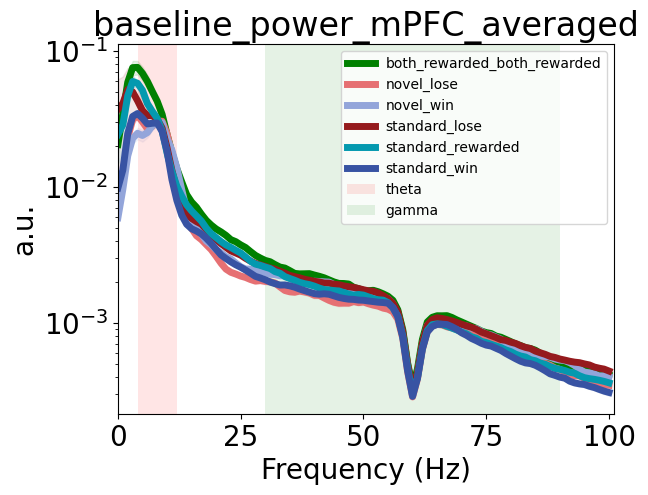

<Figure size 640x480 with 0 Axes>

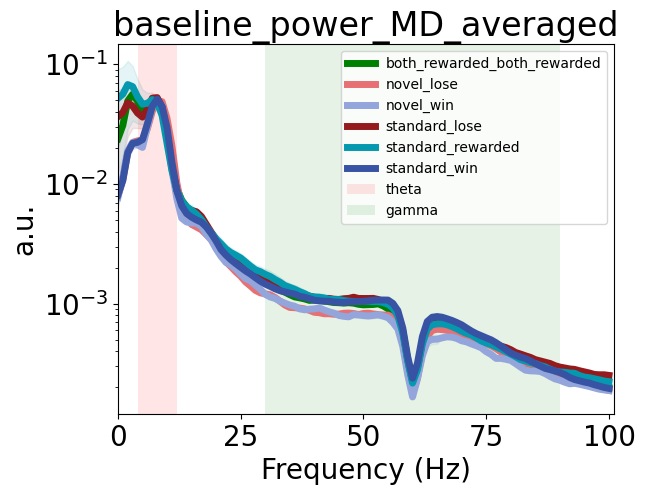

<Figure size 640x480 with 0 Axes>

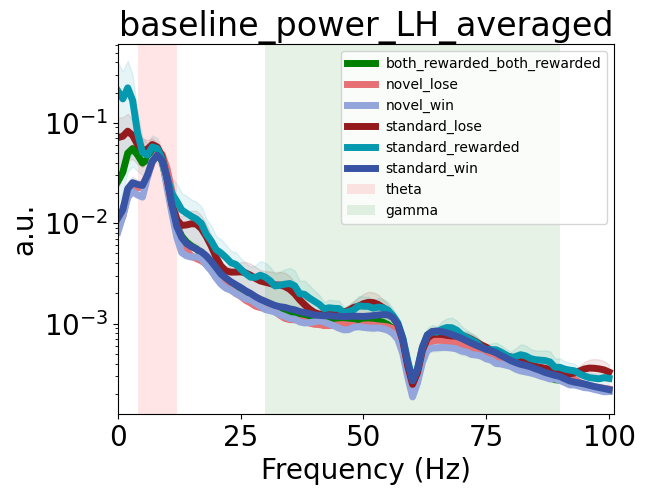

<Figure size 640x480 with 0 Axes>

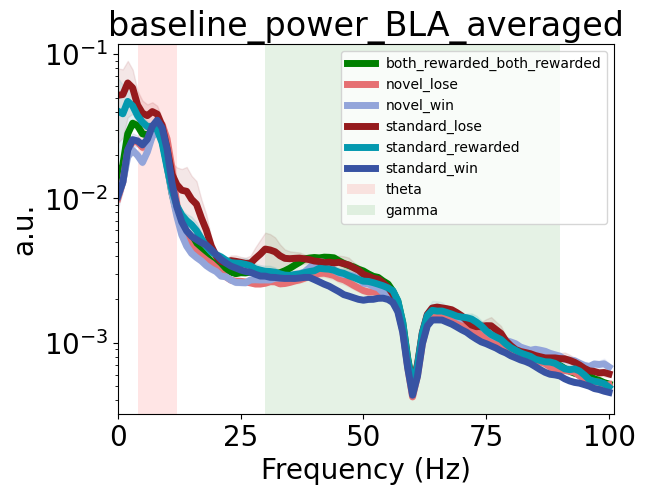

<Figure size 640x480 with 0 Axes>

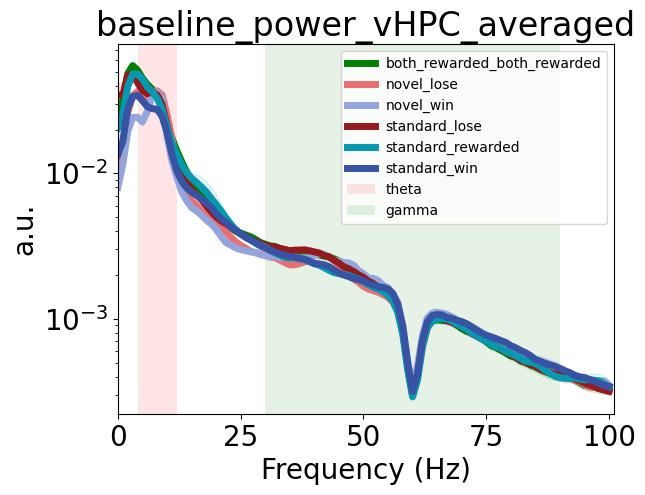

<Figure size 640x480 with 0 Axes>

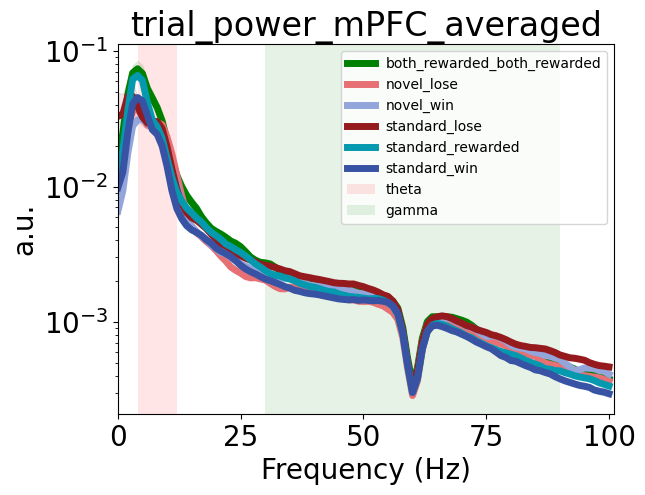

<Figure size 640x480 with 0 Axes>

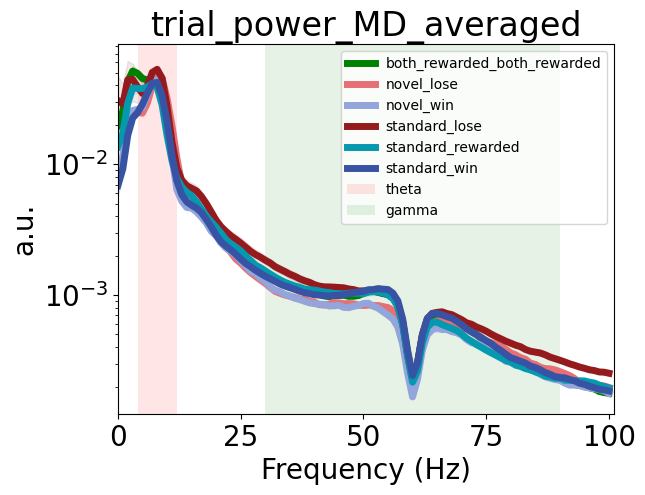

<Figure size 640x480 with 0 Axes>

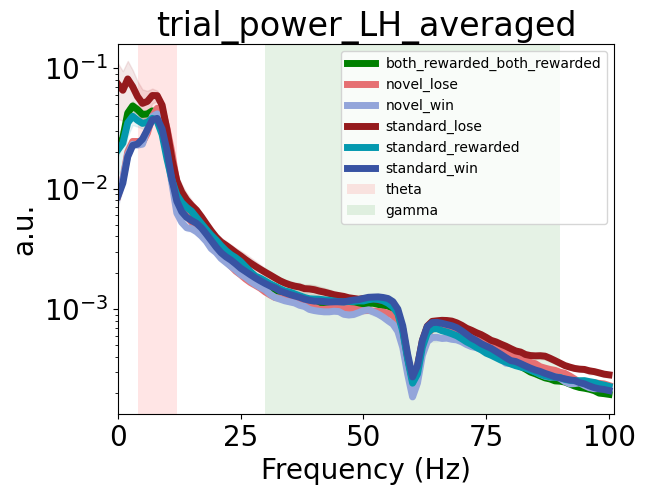

<Figure size 640x480 with 0 Axes>

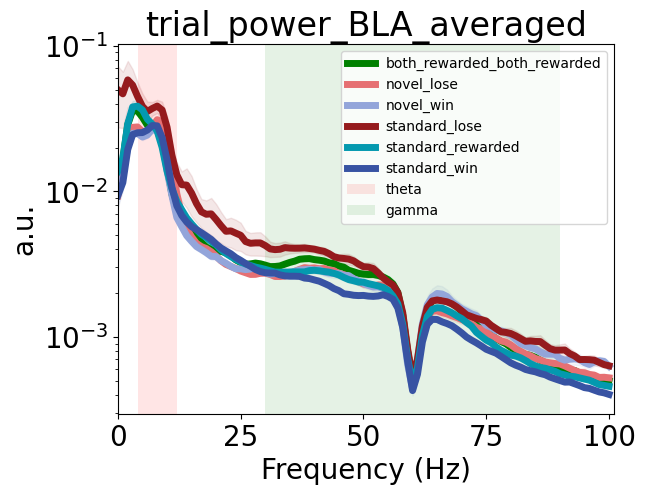

<Figure size 640x480 with 0 Axes>

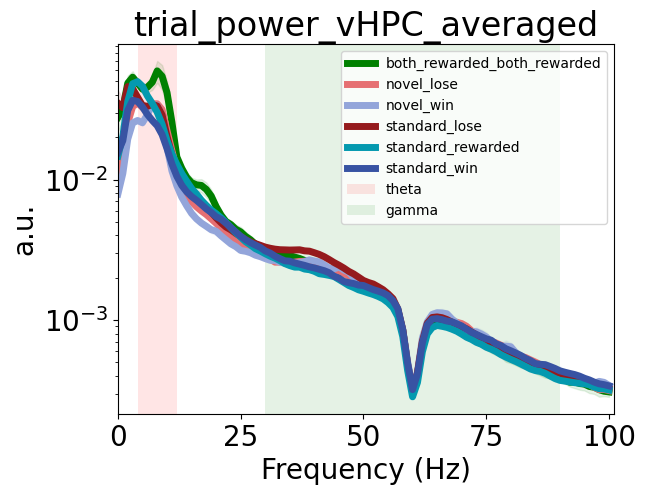

<Figure size 640x480 with 0 Axes>

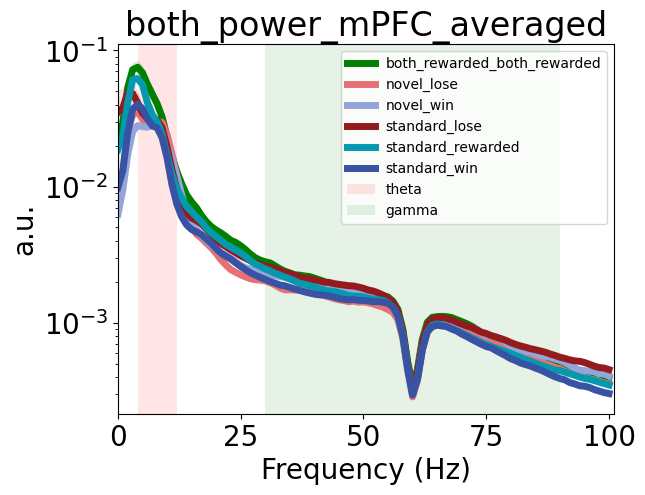

<Figure size 640x480 with 0 Axes>

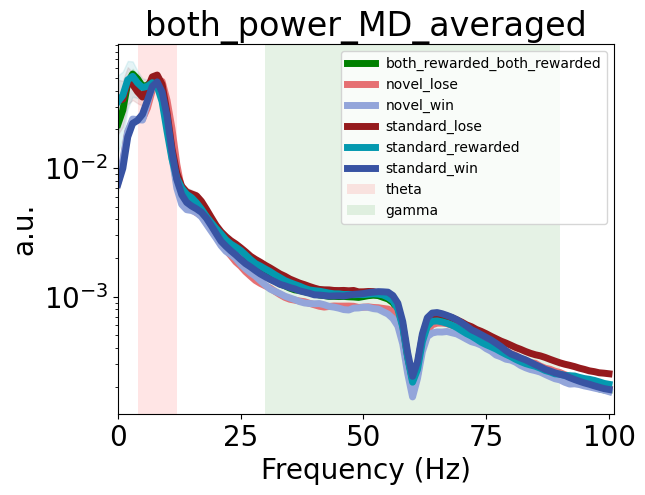

<Figure size 640x480 with 0 Axes>

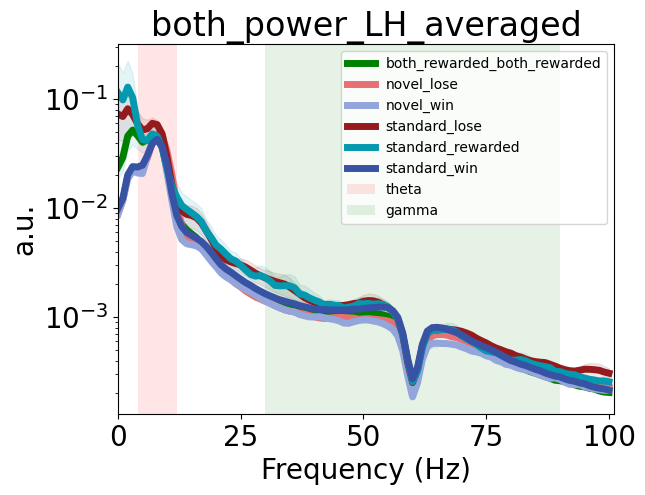

<Figure size 640x480 with 0 Axes>

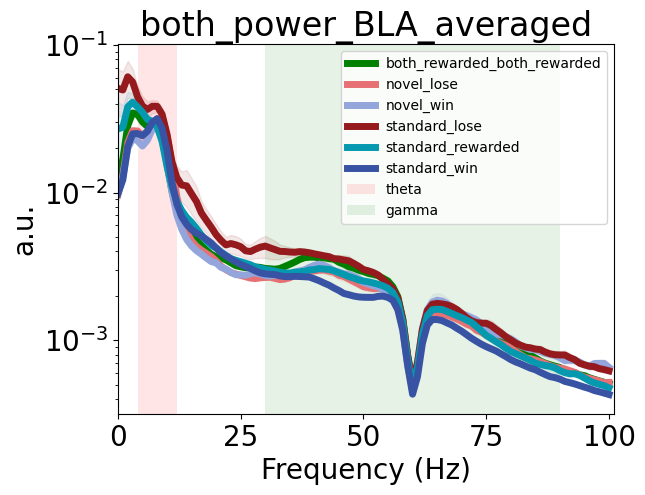

<Figure size 640x480 with 0 Axes>

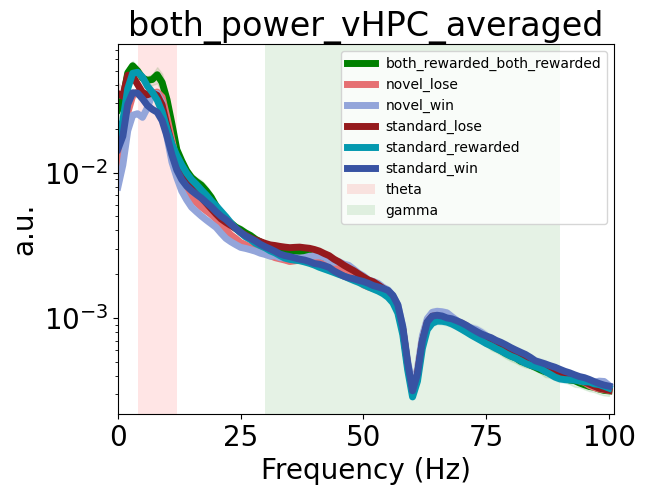

<Figure size 640x480 with 0 Axes>

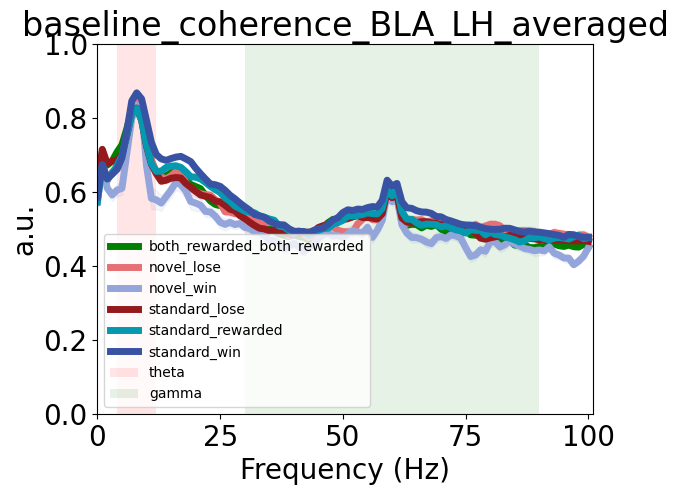

<Figure size 640x480 with 0 Axes>

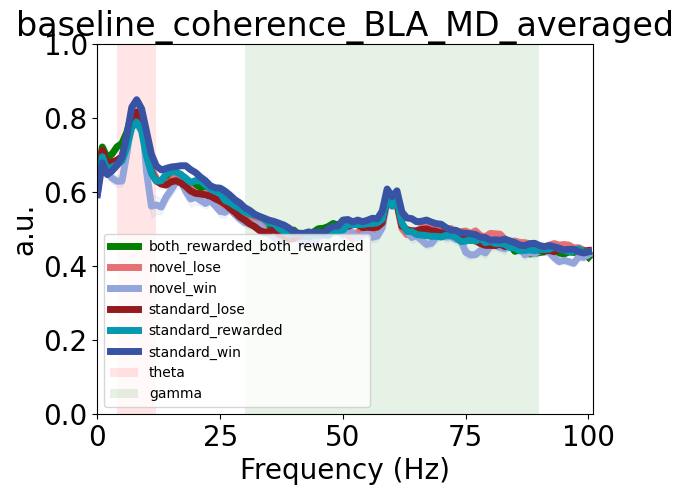

<Figure size 640x480 with 0 Axes>

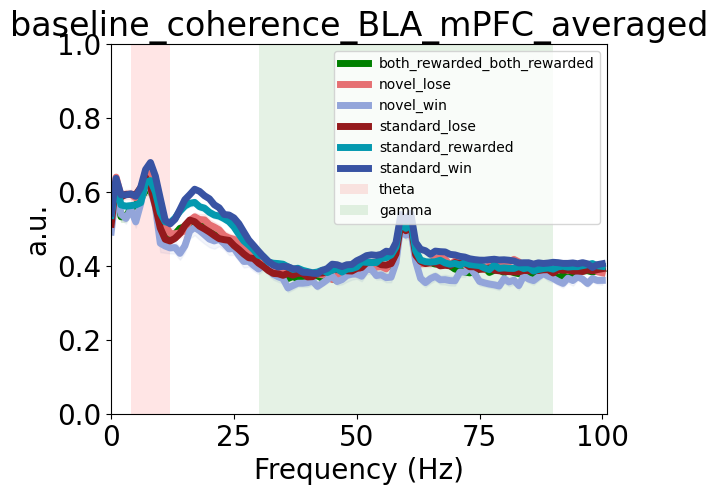

<Figure size 640x480 with 0 Axes>

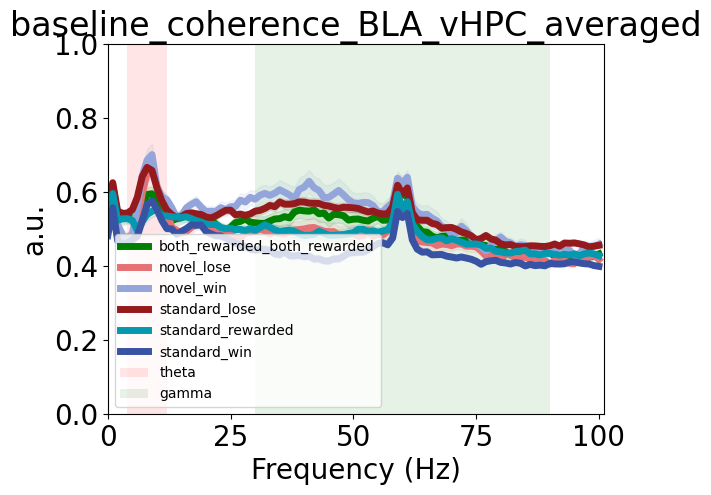

<Figure size 640x480 with 0 Axes>

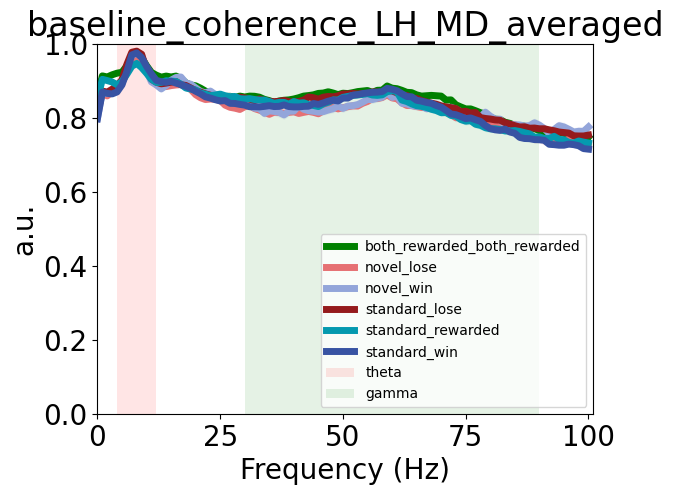

<Figure size 640x480 with 0 Axes>

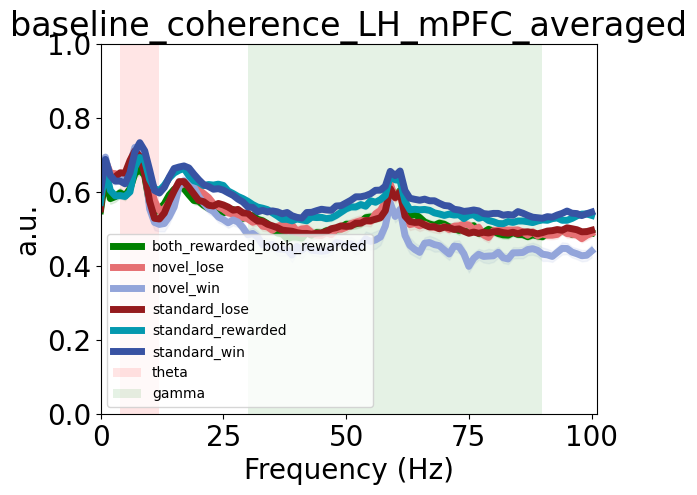

<Figure size 640x480 with 0 Axes>

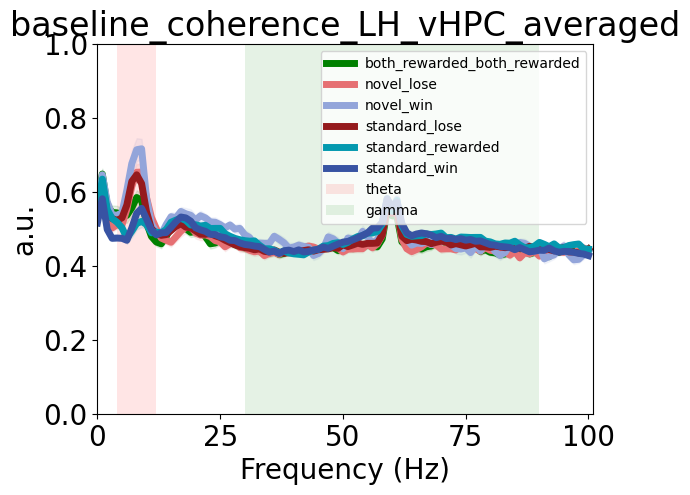

<Figure size 640x480 with 0 Axes>

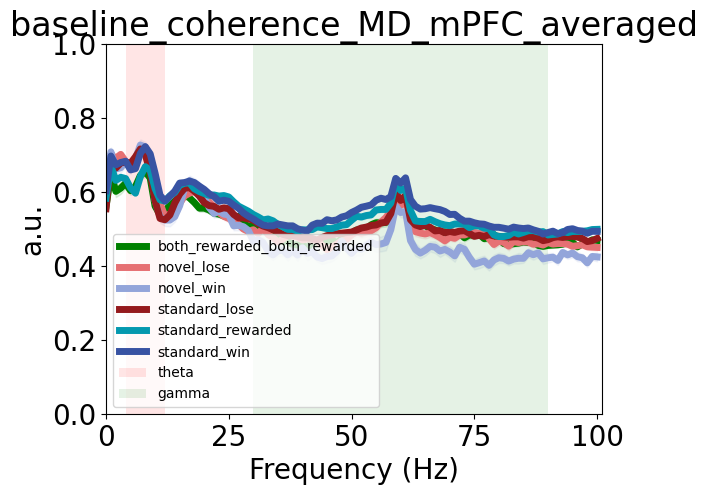

<Figure size 640x480 with 0 Axes>

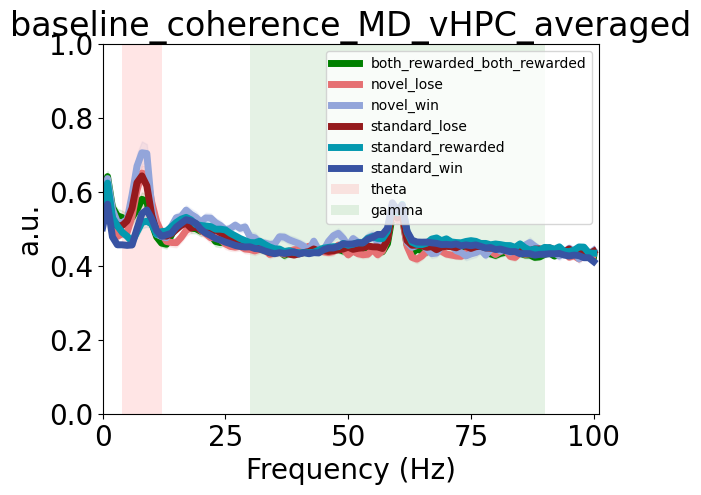

<Figure size 640x480 with 0 Axes>

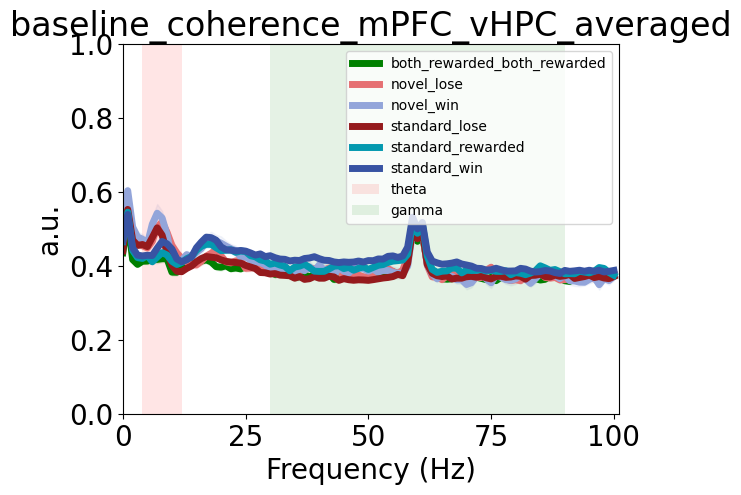

<Figure size 640x480 with 0 Axes>

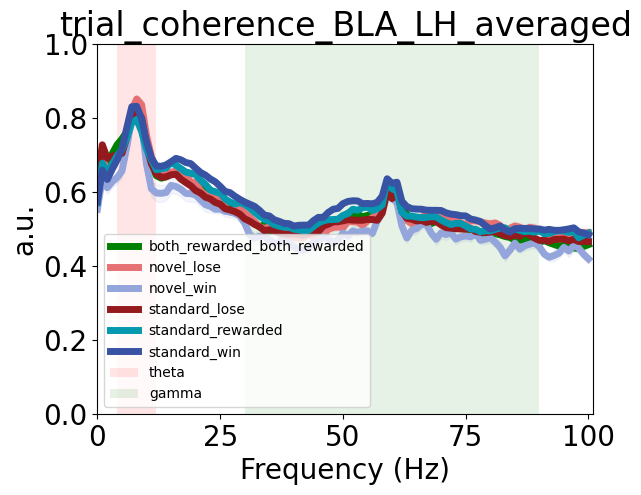

<Figure size 640x480 with 0 Axes>

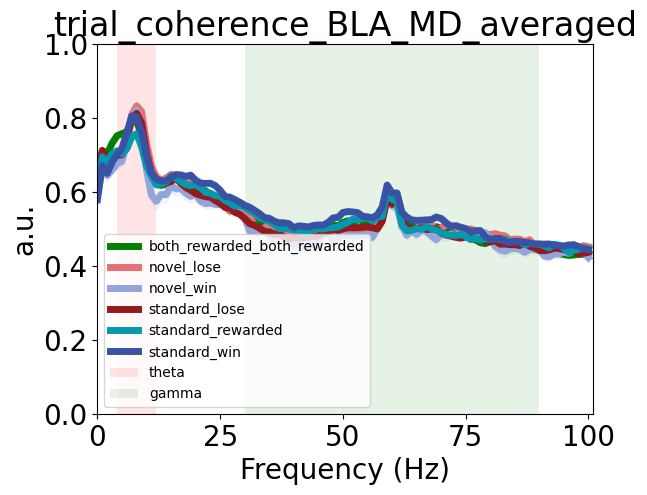

<Figure size 640x480 with 0 Axes>

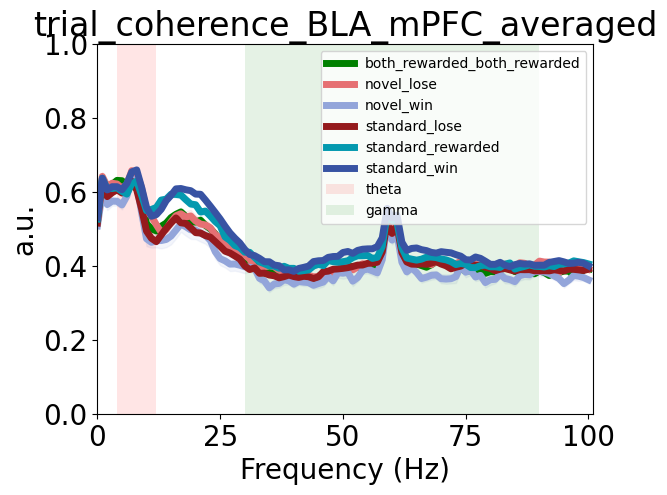

<Figure size 640x480 with 0 Axes>

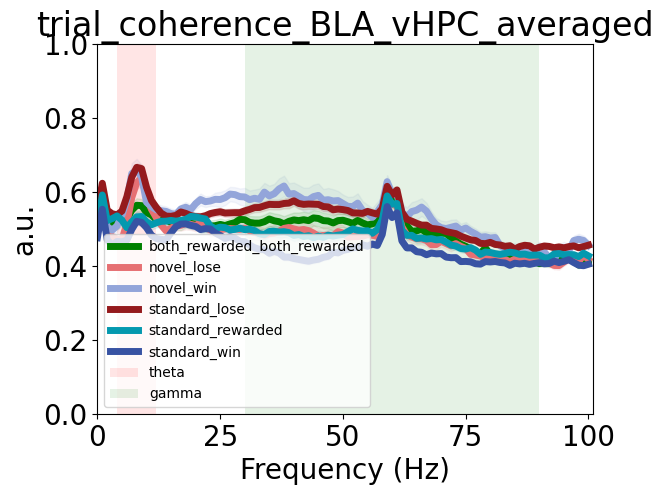

<Figure size 640x480 with 0 Axes>

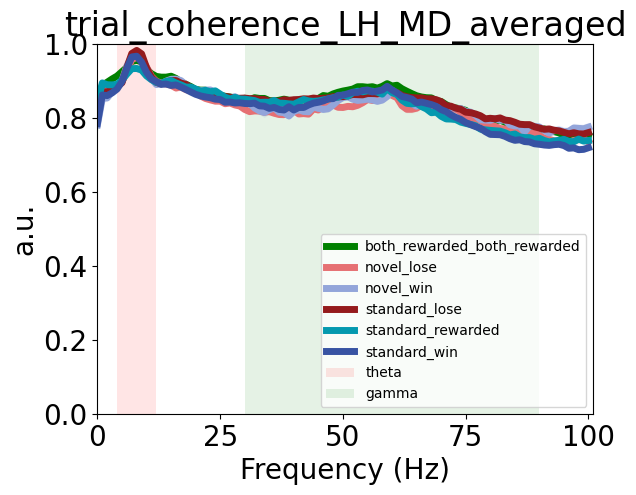

<Figure size 640x480 with 0 Axes>

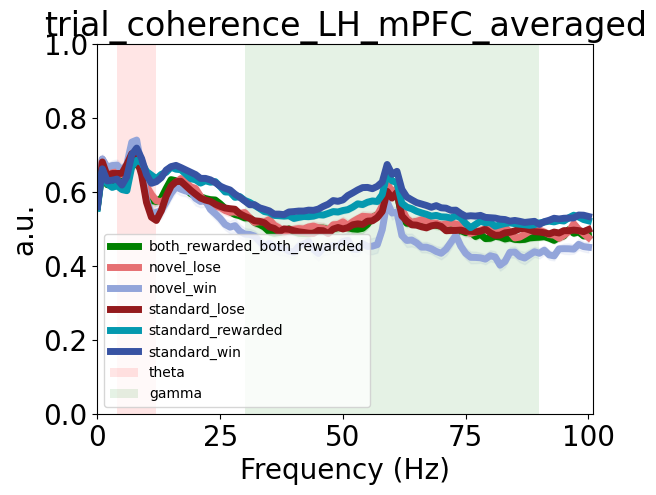

<Figure size 640x480 with 0 Axes>

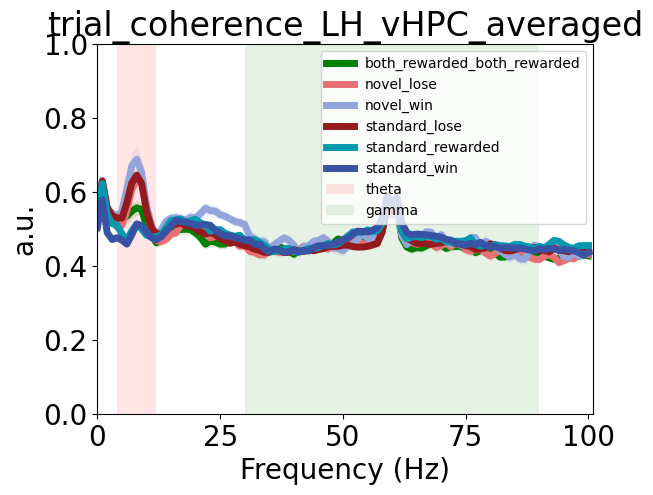

<Figure size 640x480 with 0 Axes>

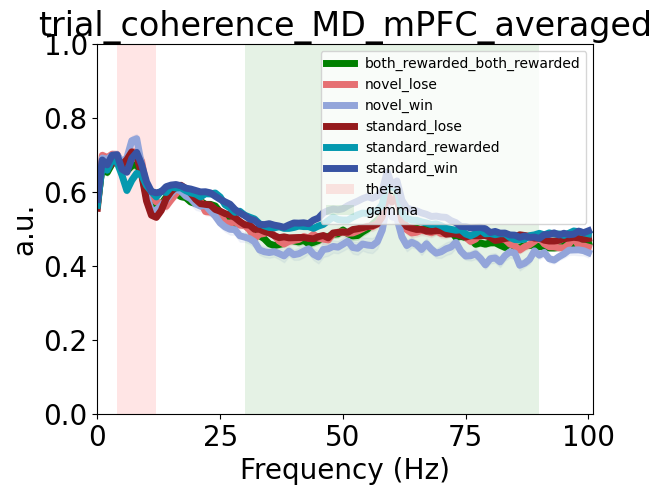

<Figure size 640x480 with 0 Axes>

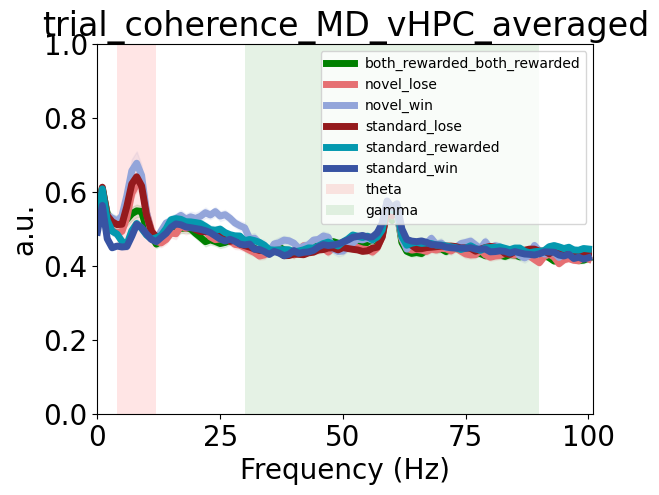

<Figure size 640x480 with 0 Axes>

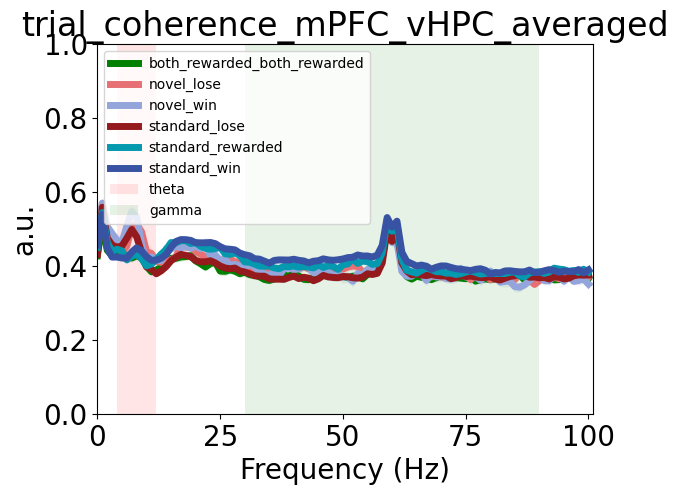

<Figure size 640x480 with 0 Axes>

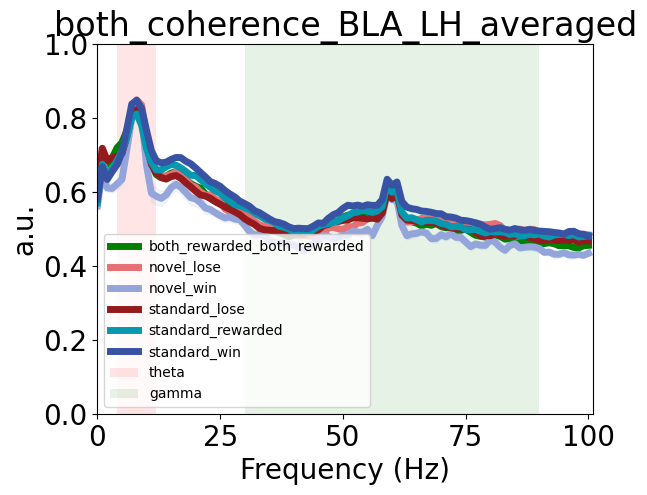

<Figure size 640x480 with 0 Axes>

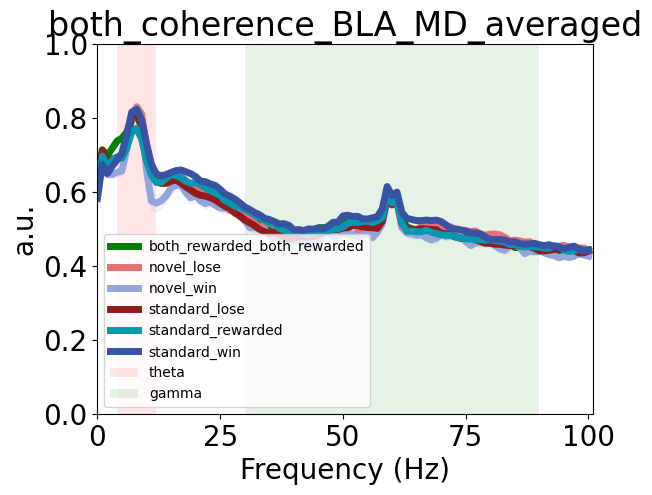

<Figure size 640x480 with 0 Axes>

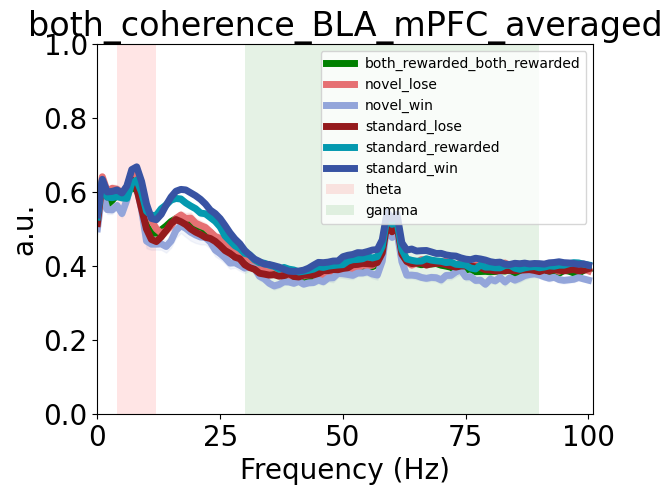

<Figure size 640x480 with 0 Axes>

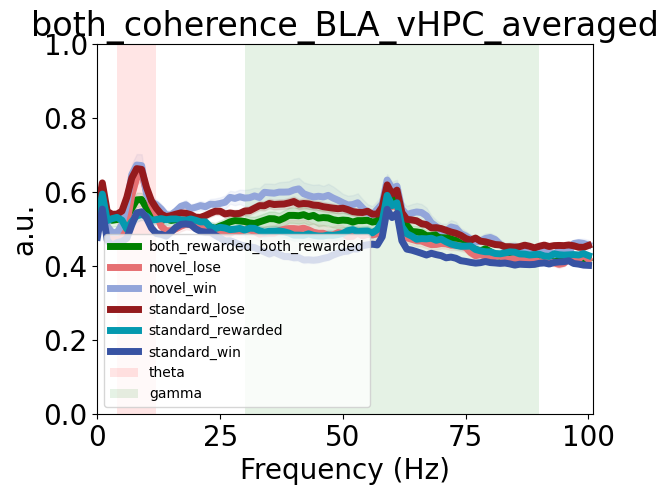

<Figure size 640x480 with 0 Axes>

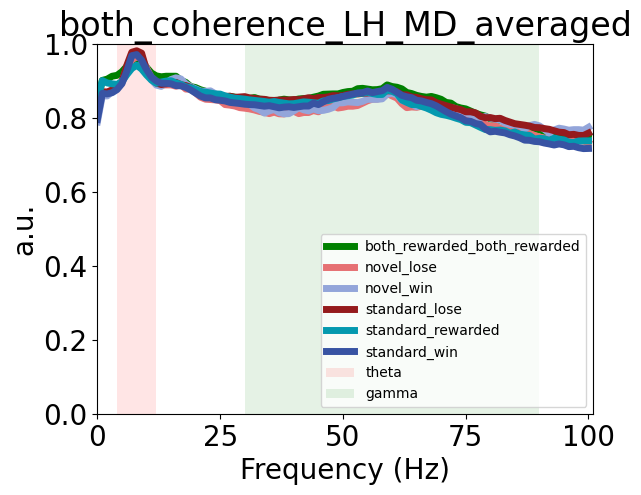

<Figure size 640x480 with 0 Axes>

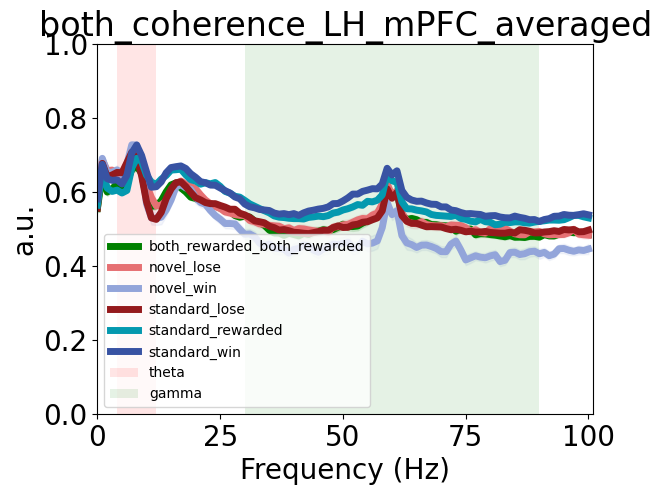

<Figure size 640x480 with 0 Axes>

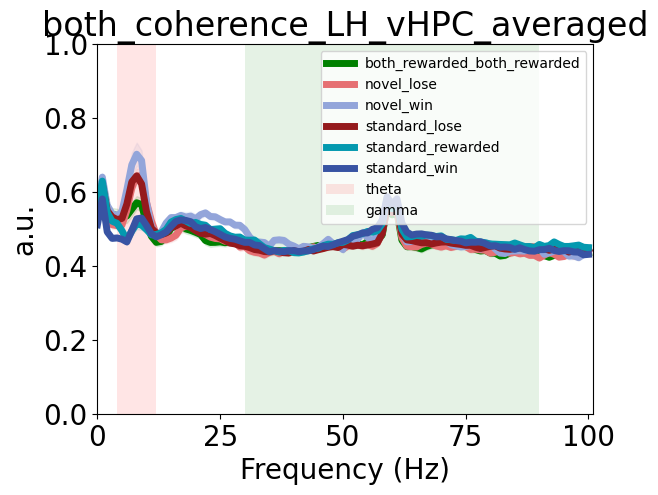

<Figure size 640x480 with 0 Axes>

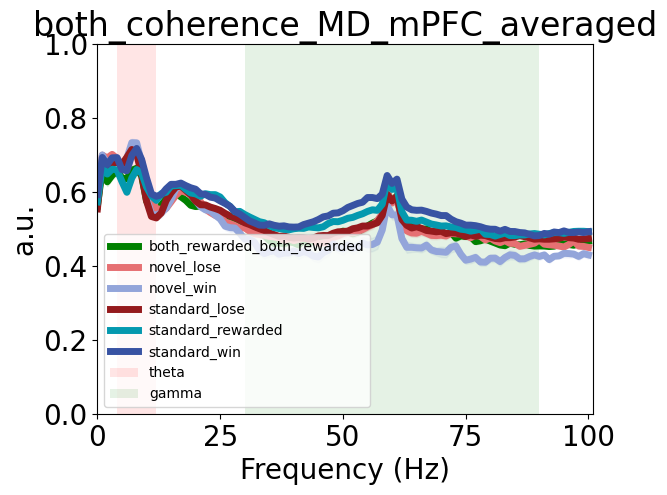

<Figure size 640x480 with 0 Axes>

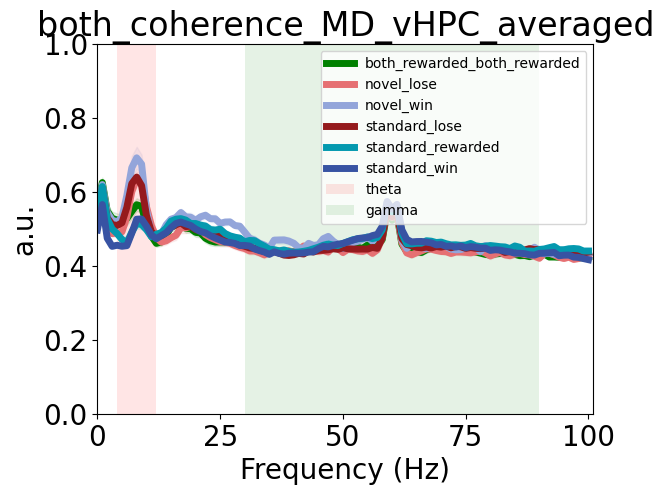

<Figure size 640x480 with 0 Axes>

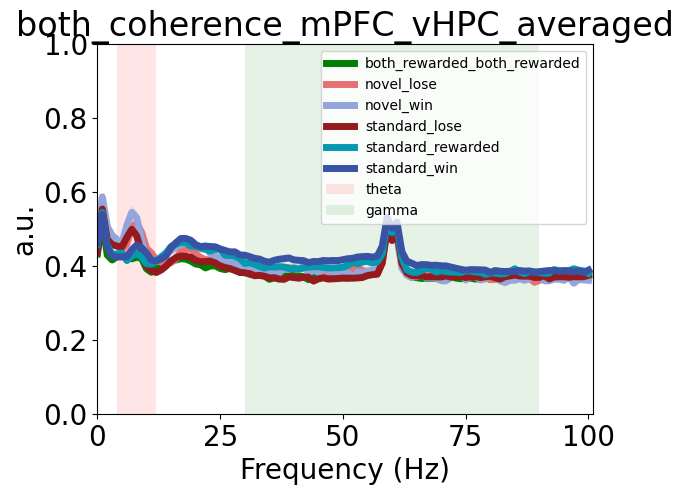

<Figure size 640x480 with 0 Axes>

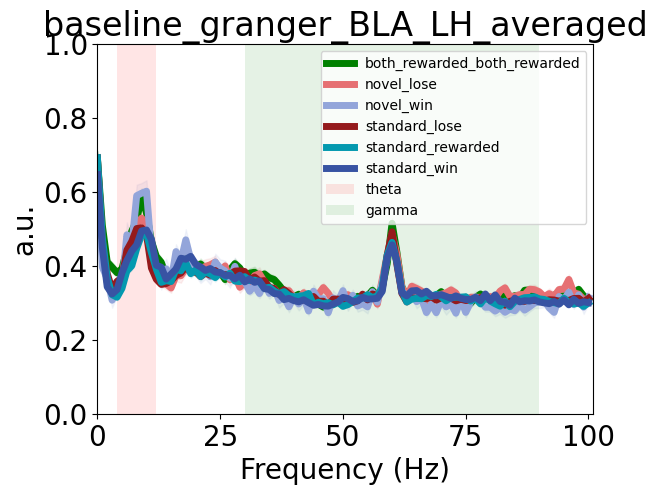

<Figure size 640x480 with 0 Axes>

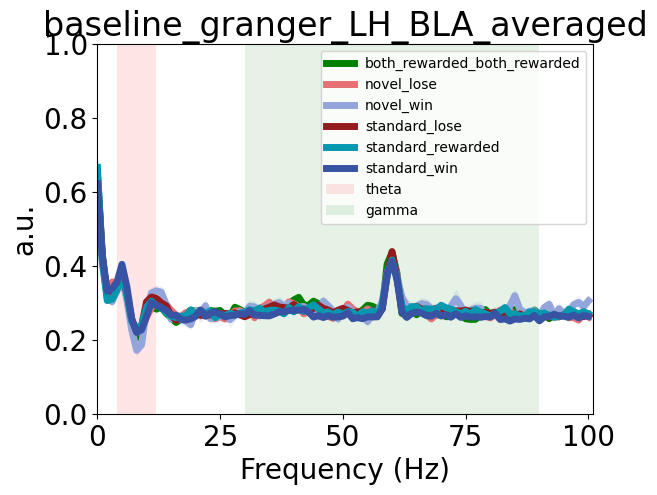

<Figure size 640x480 with 0 Axes>

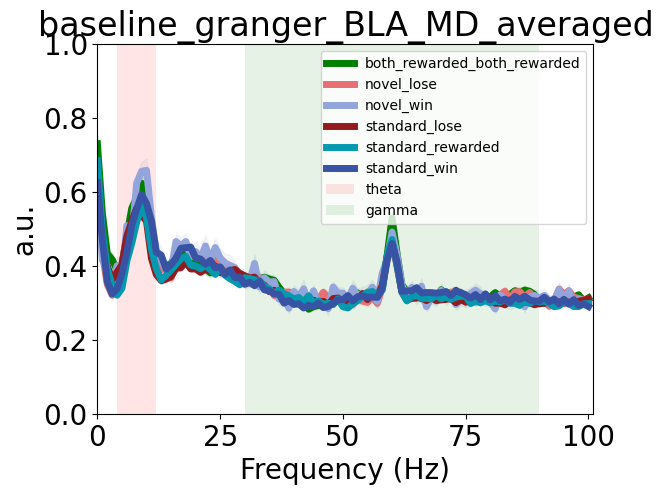

<Figure size 640x480 with 0 Axes>

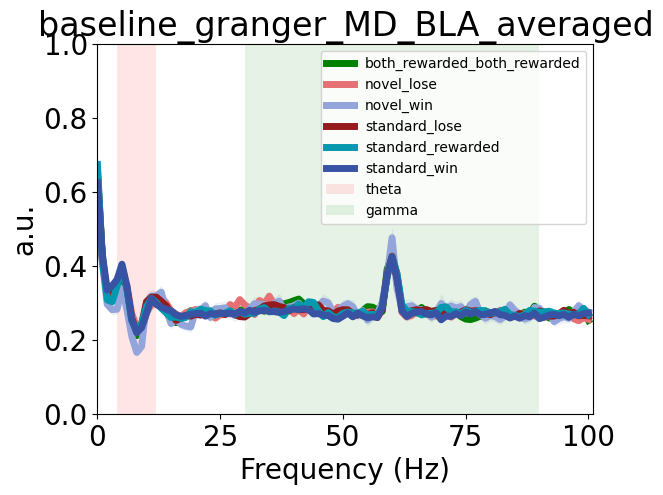

<Figure size 640x480 with 0 Axes>

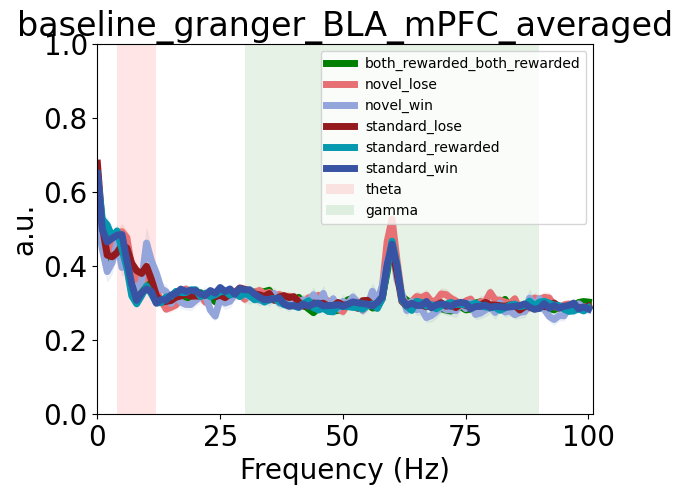

<Figure size 640x480 with 0 Axes>

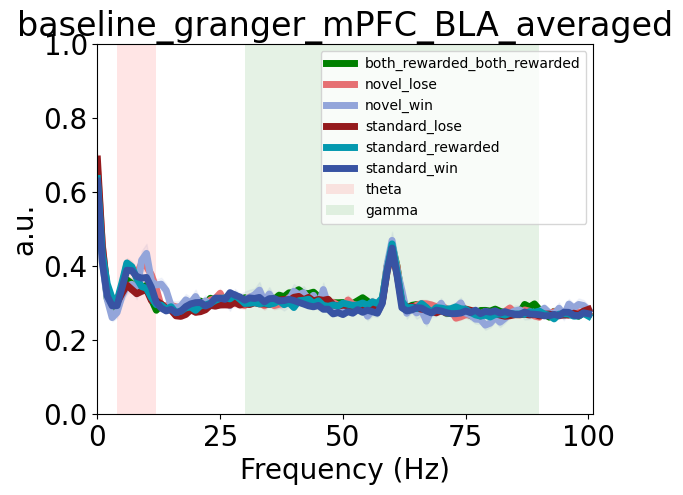

<Figure size 640x480 with 0 Axes>

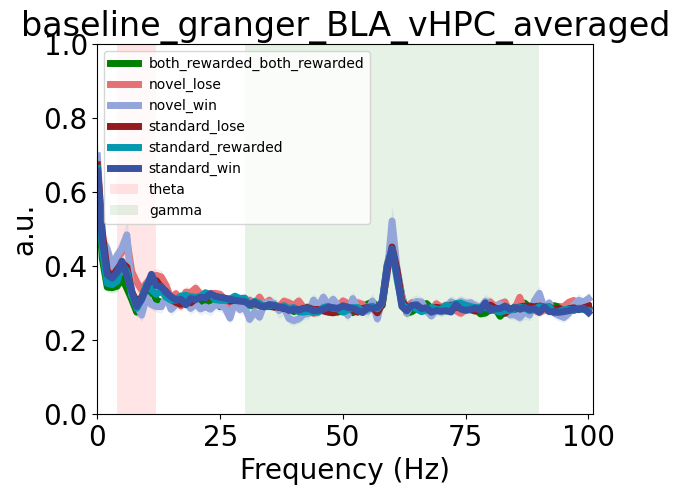

<Figure size 640x480 with 0 Axes>

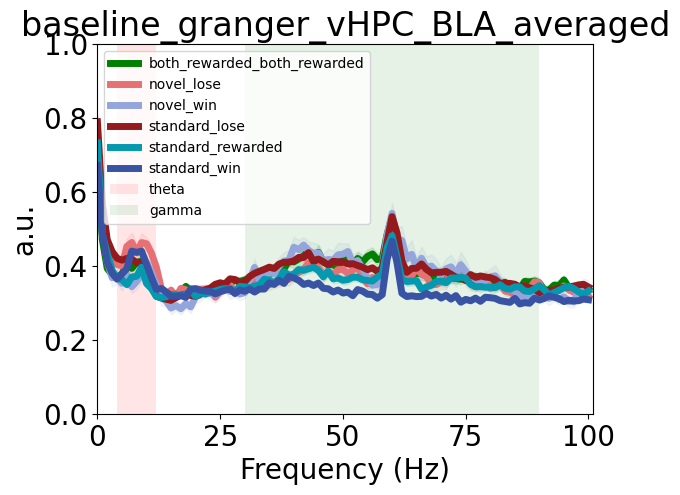

<Figure size 640x480 with 0 Axes>

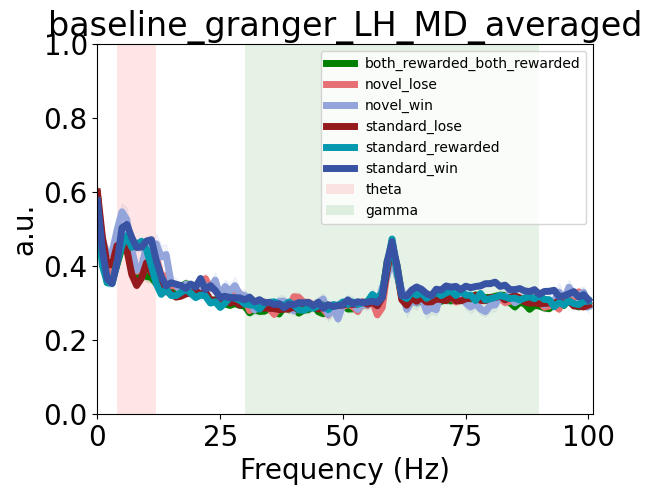

<Figure size 640x480 with 0 Axes>

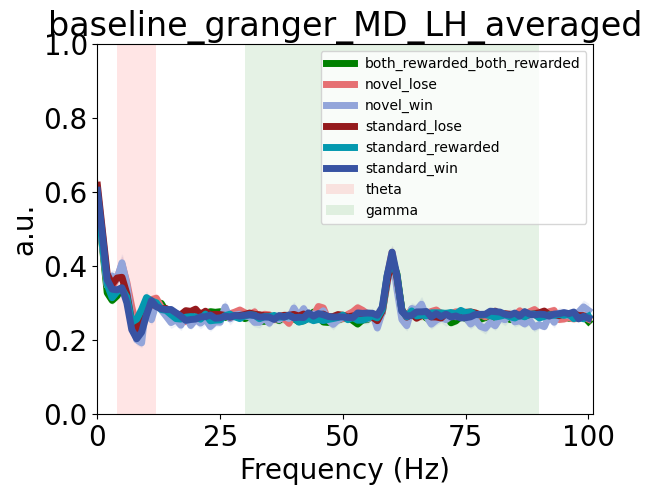

<Figure size 640x480 with 0 Axes>

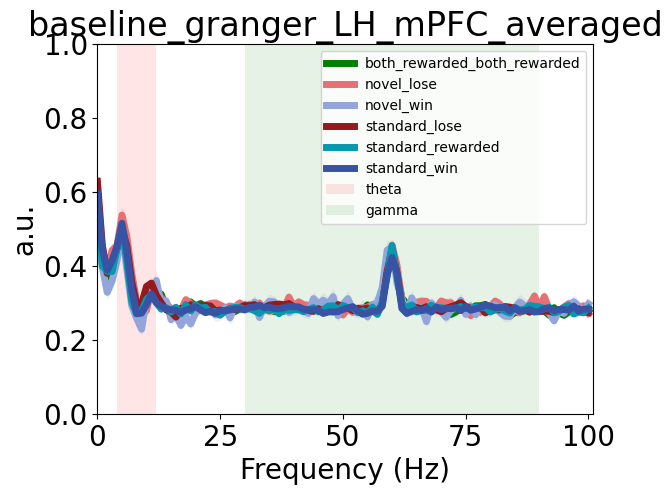

<Figure size 640x480 with 0 Axes>

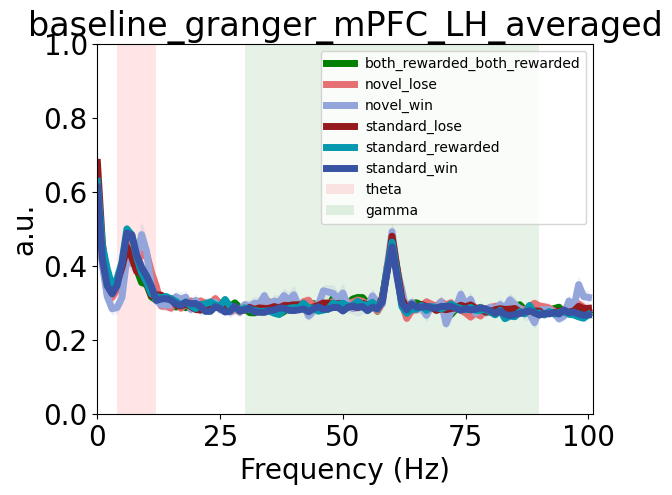

<Figure size 640x480 with 0 Axes>

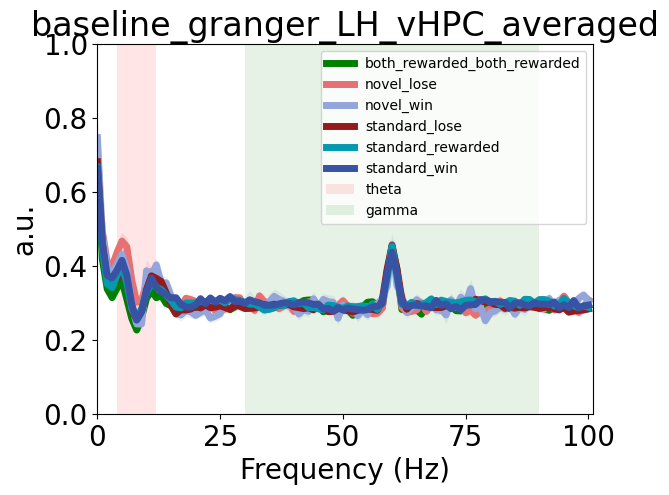

<Figure size 640x480 with 0 Axes>

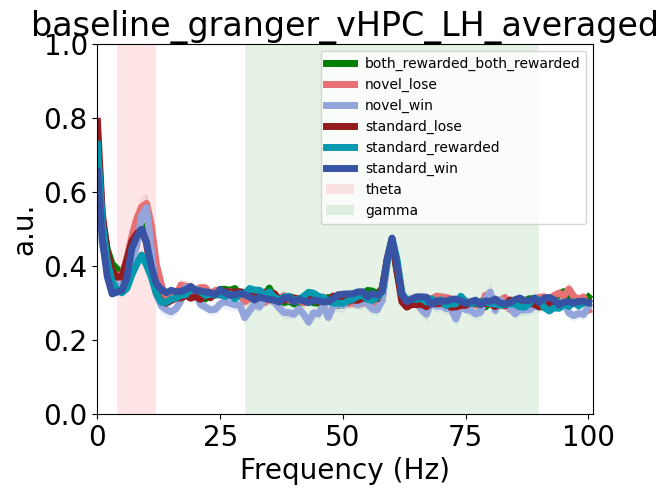

<Figure size 640x480 with 0 Axes>

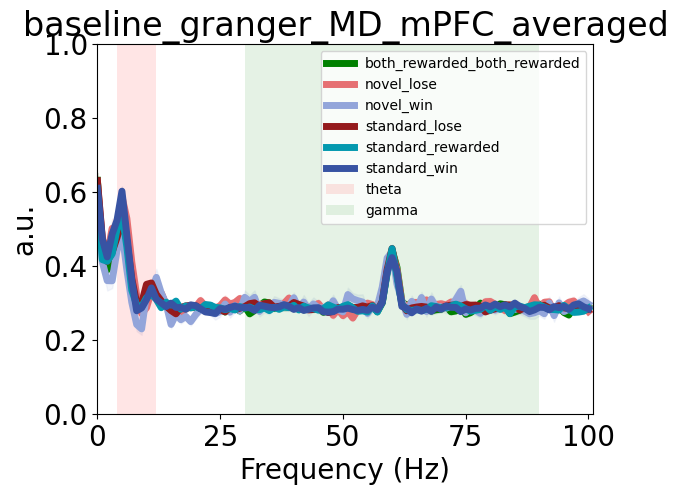

<Figure size 640x480 with 0 Axes>

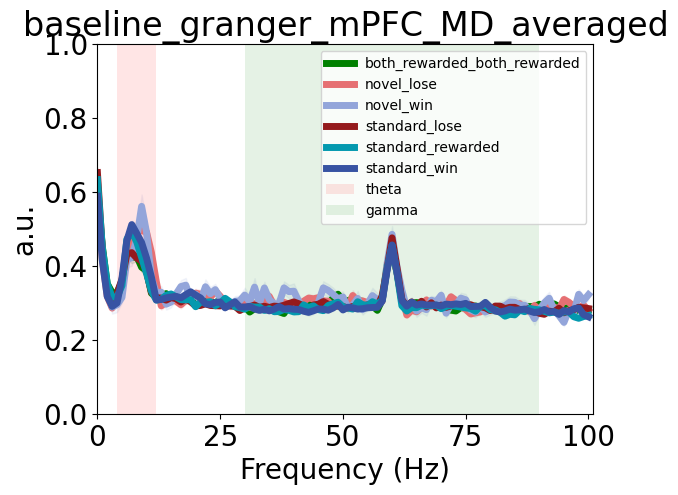

<Figure size 640x480 with 0 Axes>

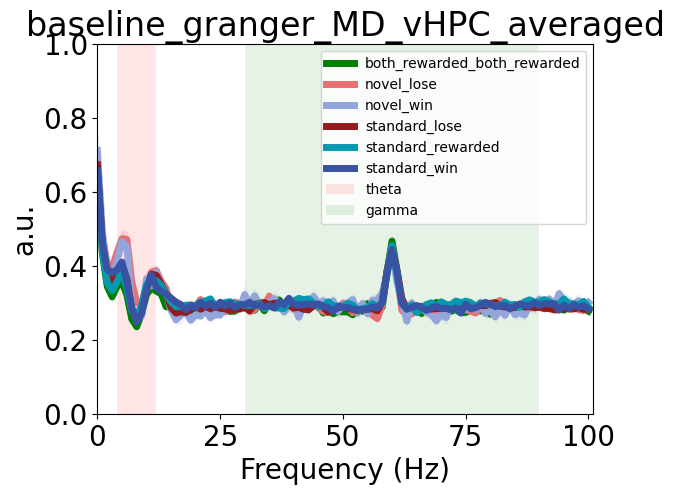

<Figure size 640x480 with 0 Axes>

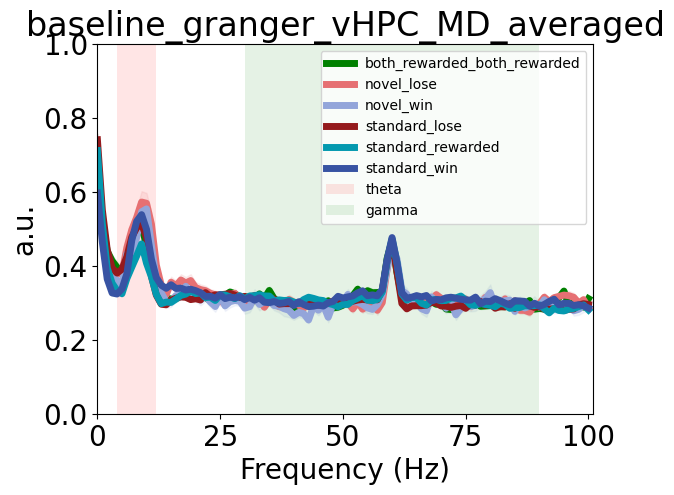

<Figure size 640x480 with 0 Axes>

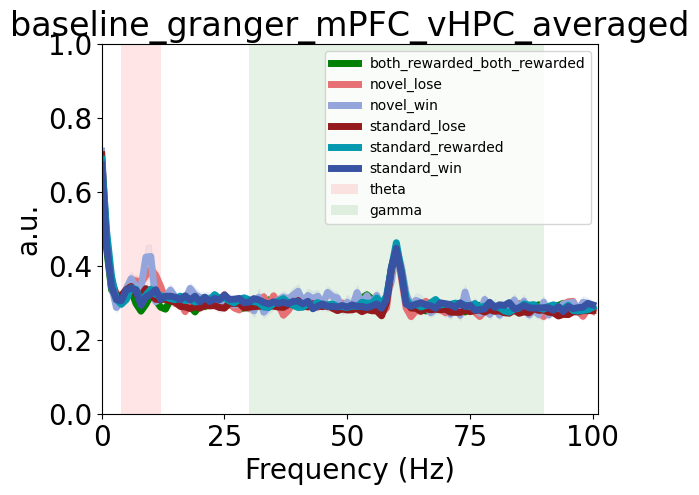

<Figure size 640x480 with 0 Axes>

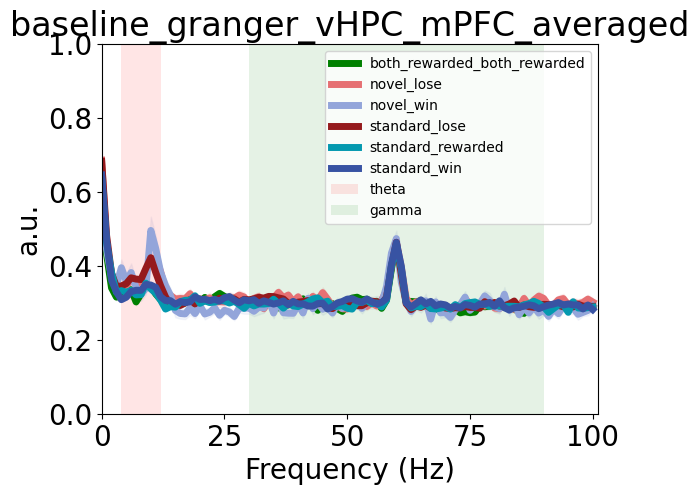

<Figure size 640x480 with 0 Axes>

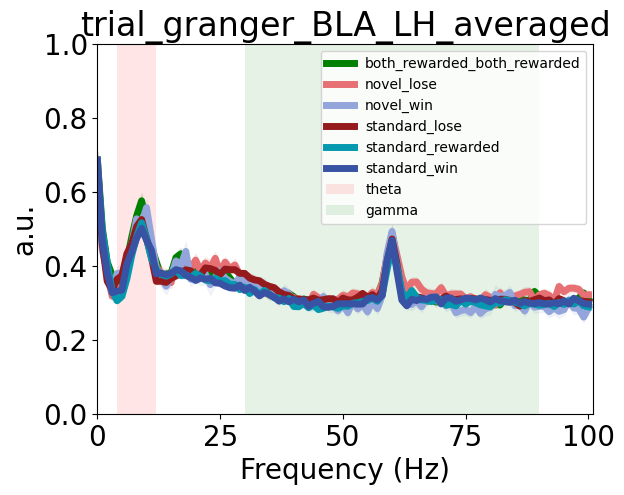

<Figure size 640x480 with 0 Axes>

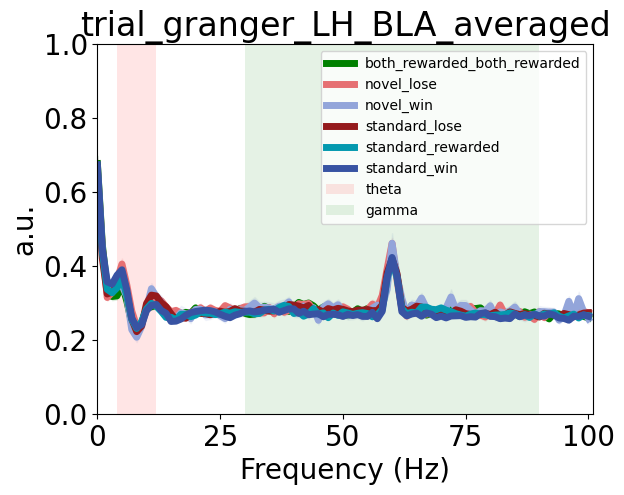

<Figure size 640x480 with 0 Axes>

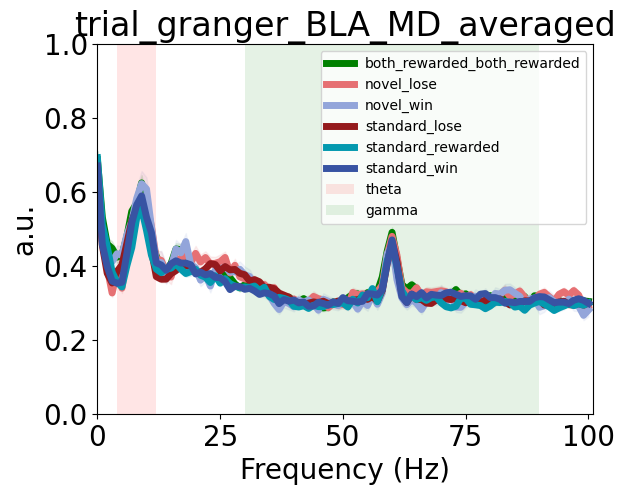

<Figure size 640x480 with 0 Axes>

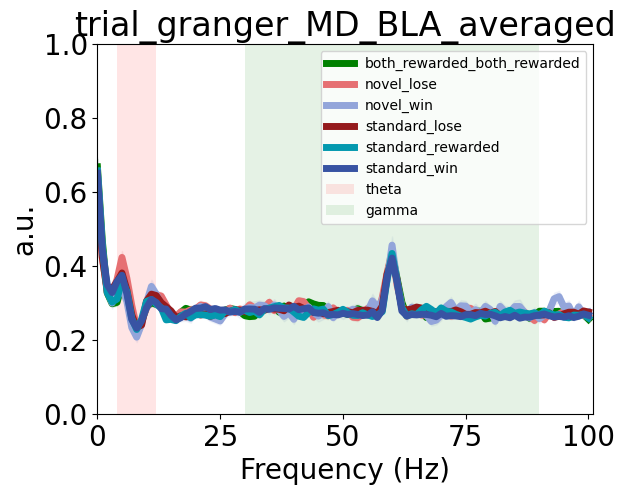

<Figure size 640x480 with 0 Axes>

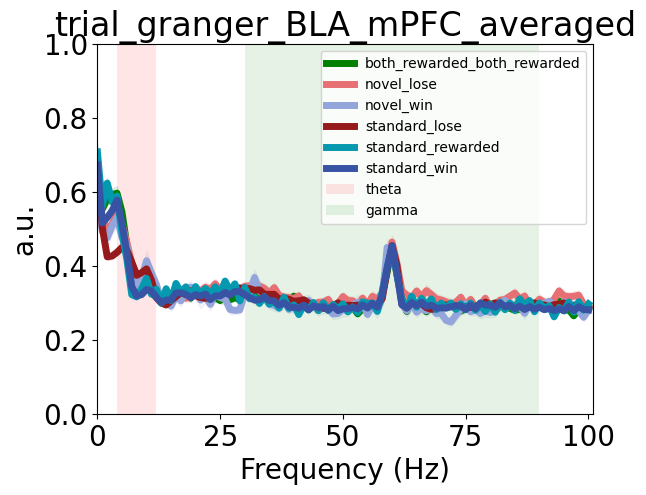

<Figure size 640x480 with 0 Axes>

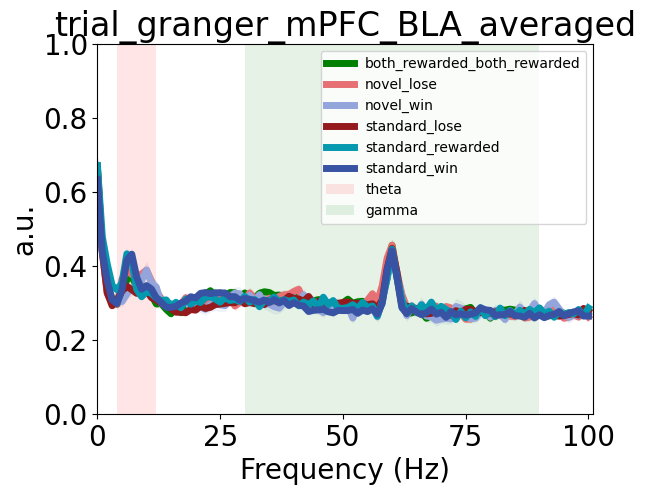

<Figure size 640x480 with 0 Axes>

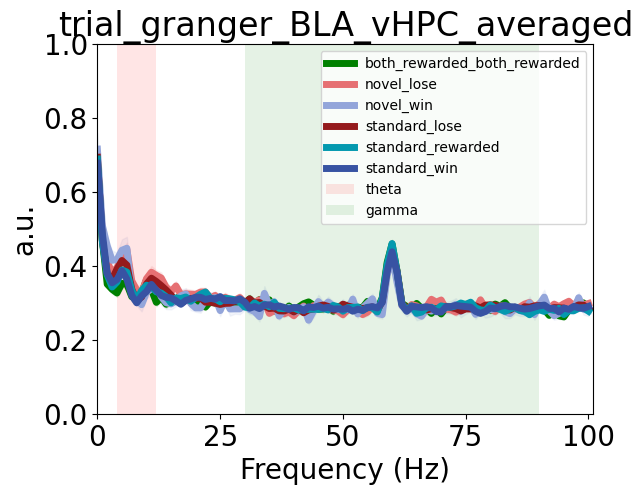

<Figure size 640x480 with 0 Axes>

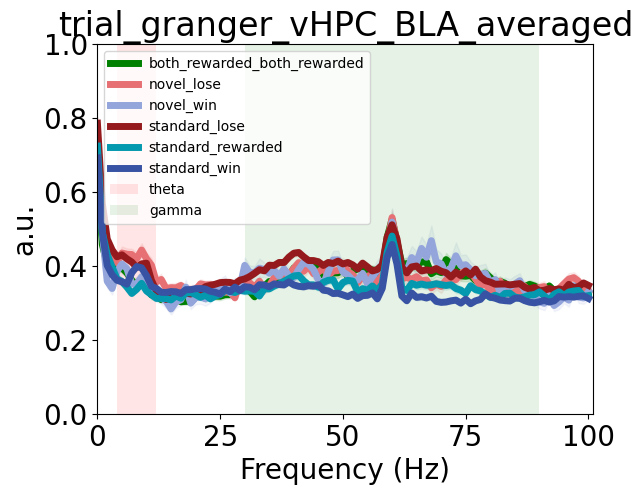

<Figure size 640x480 with 0 Axes>

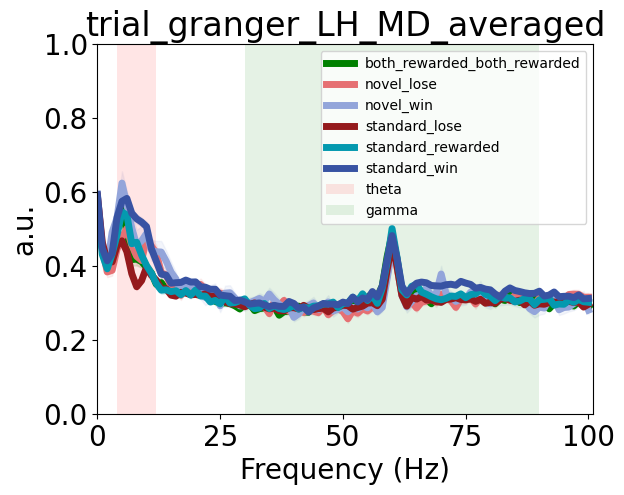

<Figure size 640x480 with 0 Axes>

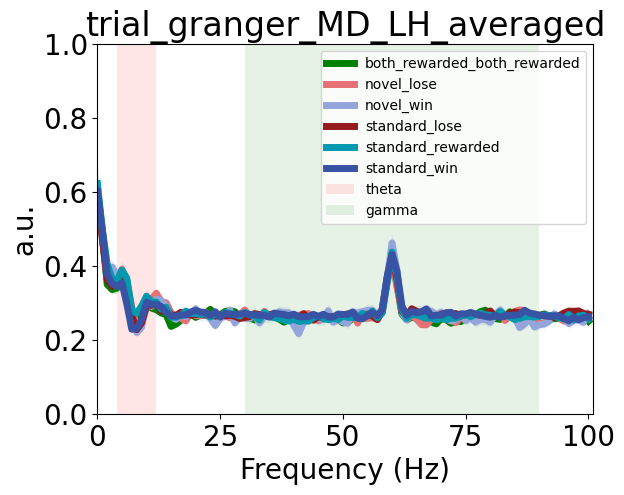

<Figure size 640x480 with 0 Axes>

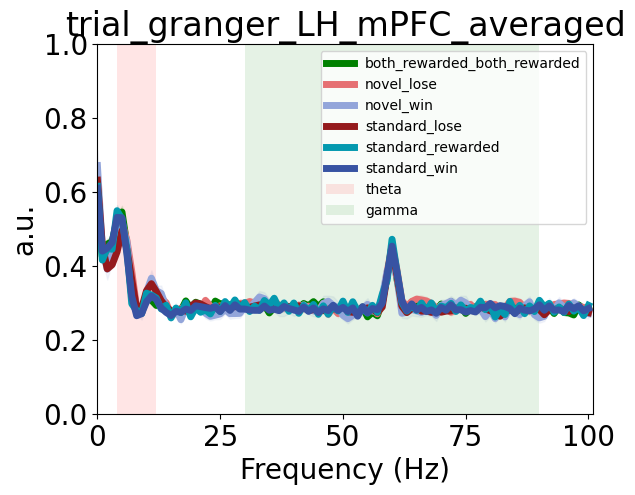

<Figure size 640x480 with 0 Axes>

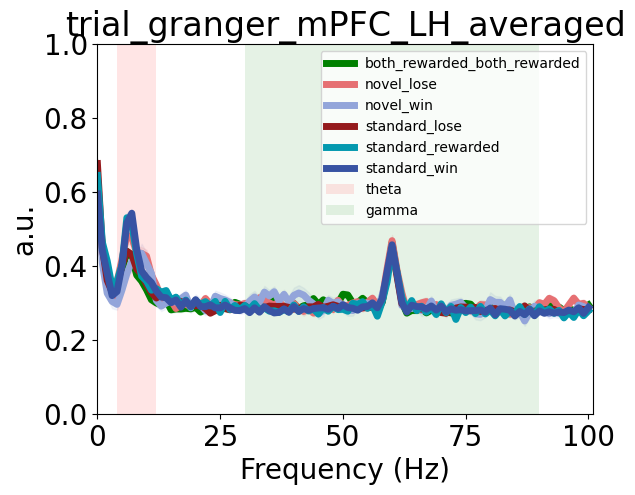

<Figure size 640x480 with 0 Axes>

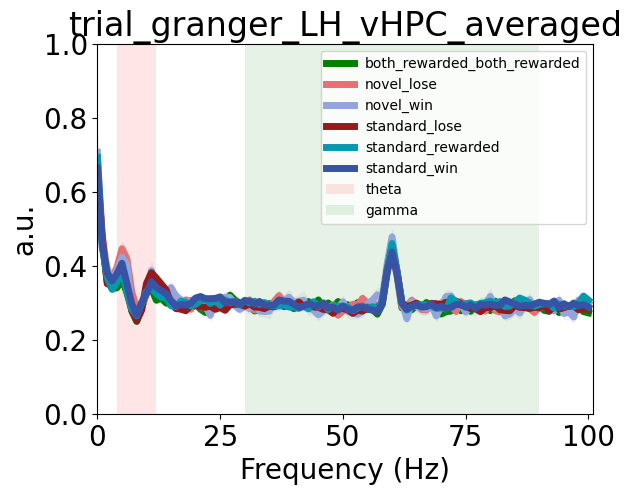

<Figure size 640x480 with 0 Axes>

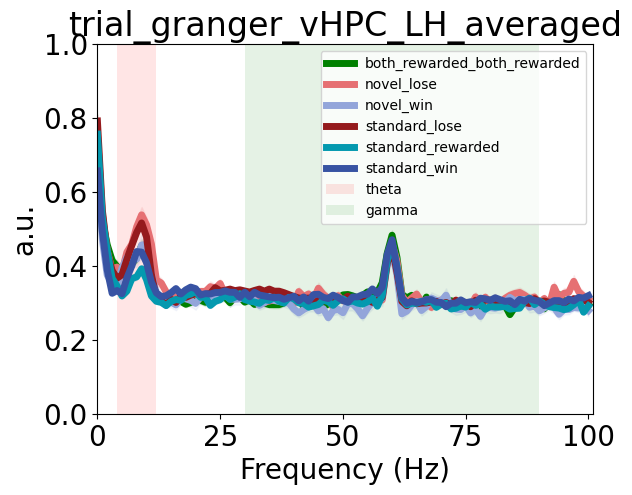

<Figure size 640x480 with 0 Axes>

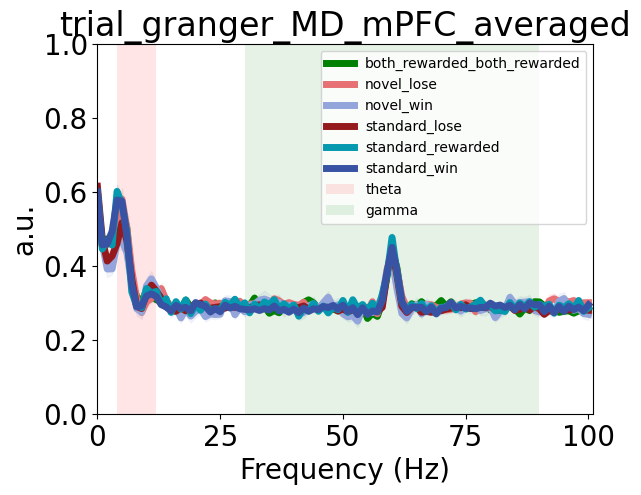

<Figure size 640x480 with 0 Axes>

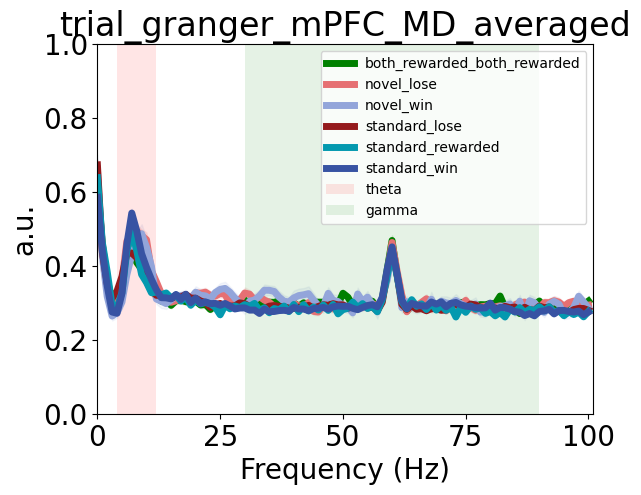

<Figure size 640x480 with 0 Axes>

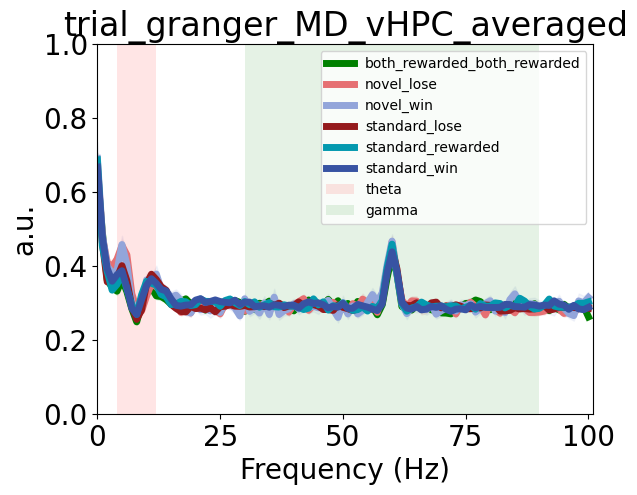

<Figure size 640x480 with 0 Axes>

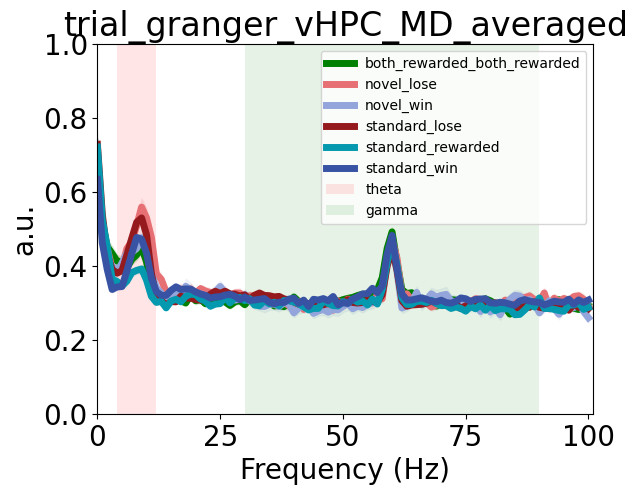

<Figure size 640x480 with 0 Axes>

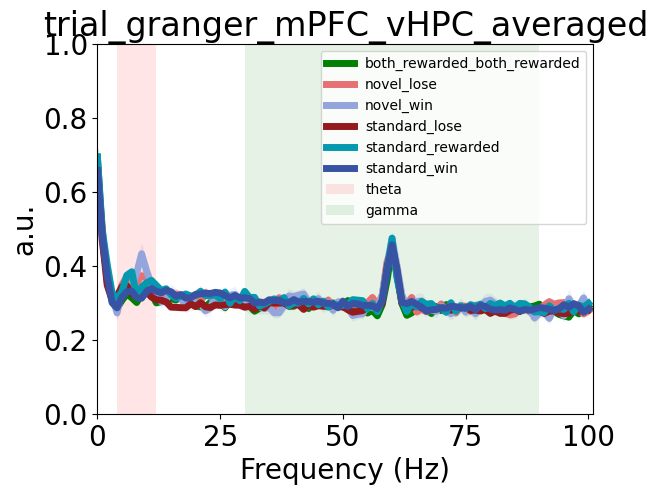

<Figure size 640x480 with 0 Axes>

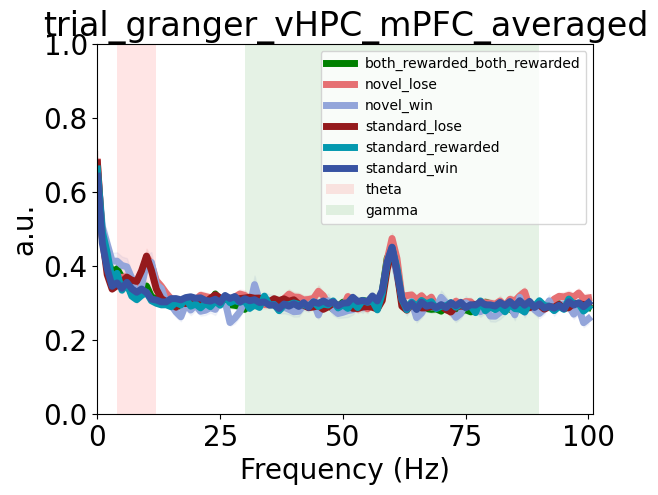

<Figure size 640x480 with 0 Axes>

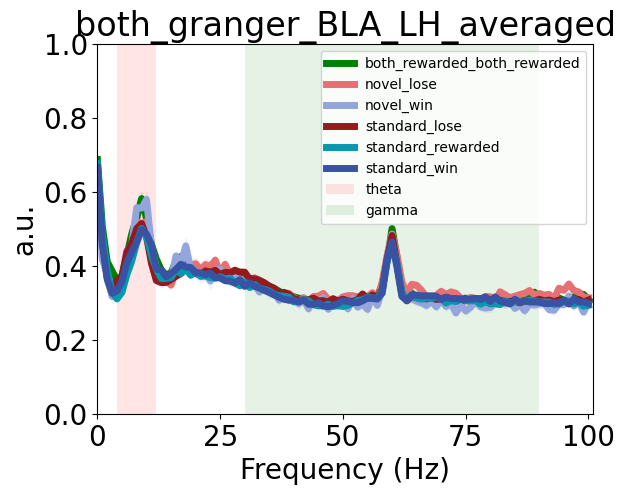

<Figure size 640x480 with 0 Axes>

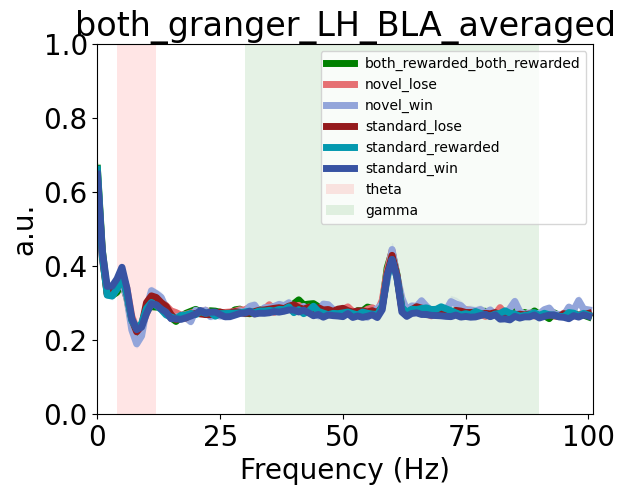

<Figure size 640x480 with 0 Axes>

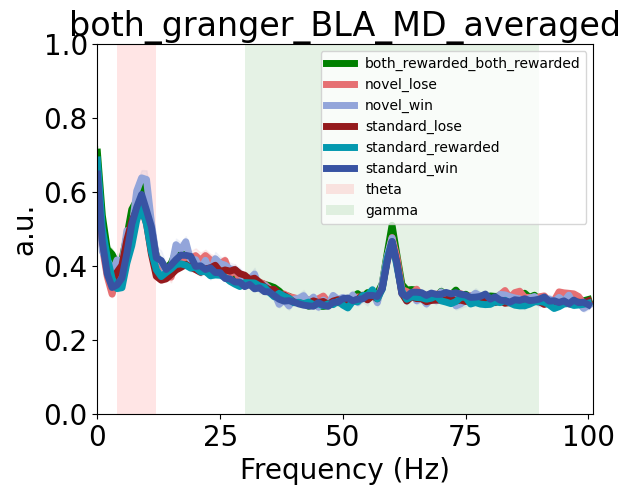

<Figure size 640x480 with 0 Axes>

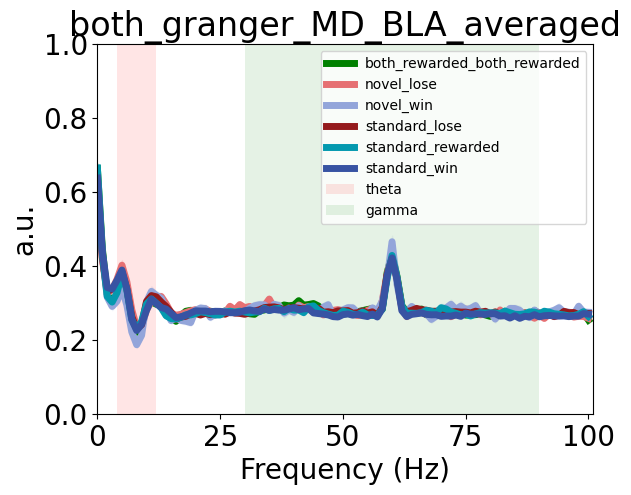

<Figure size 640x480 with 0 Axes>

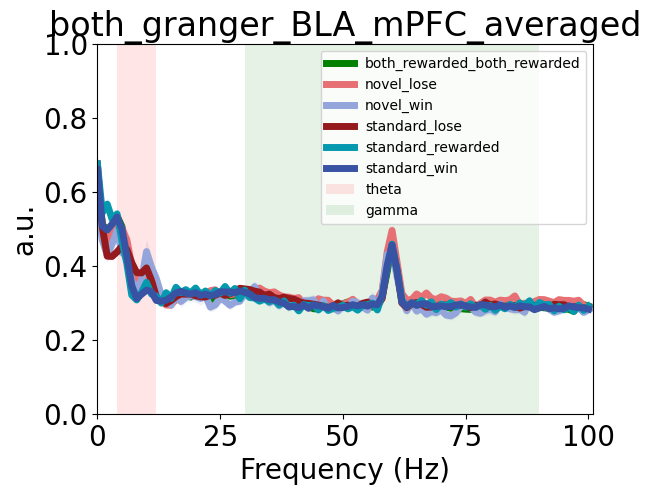

<Figure size 640x480 with 0 Axes>

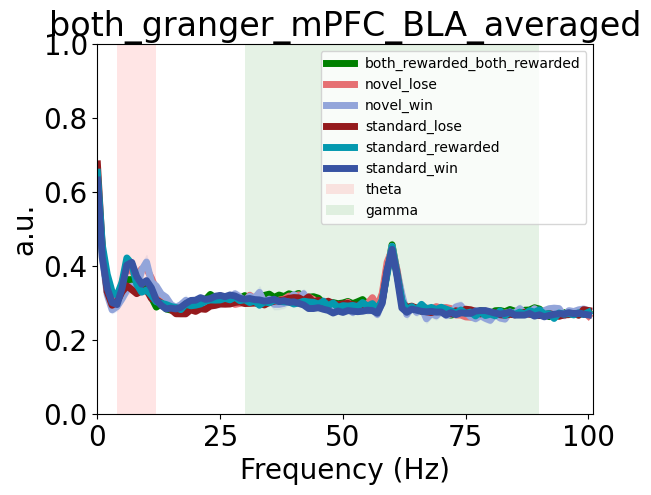

<Figure size 640x480 with 0 Axes>

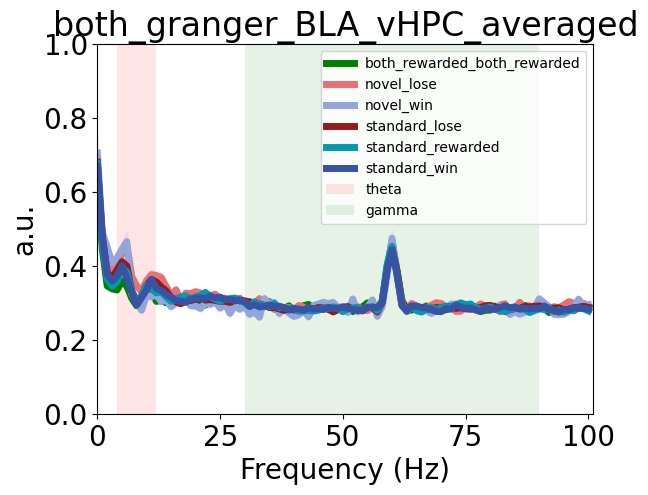

<Figure size 640x480 with 0 Axes>

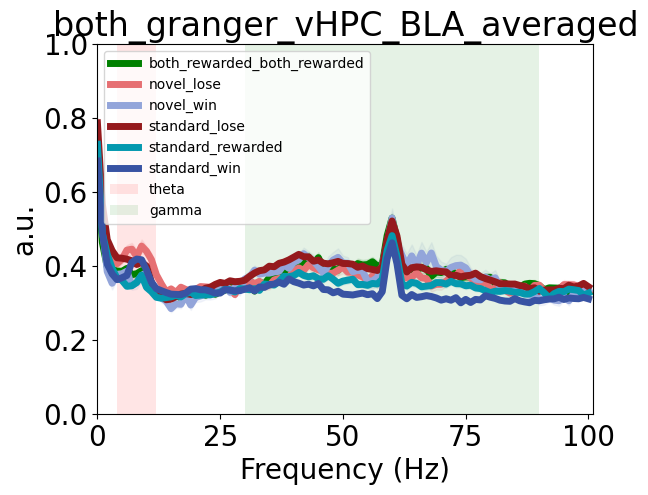

<Figure size 640x480 with 0 Axes>

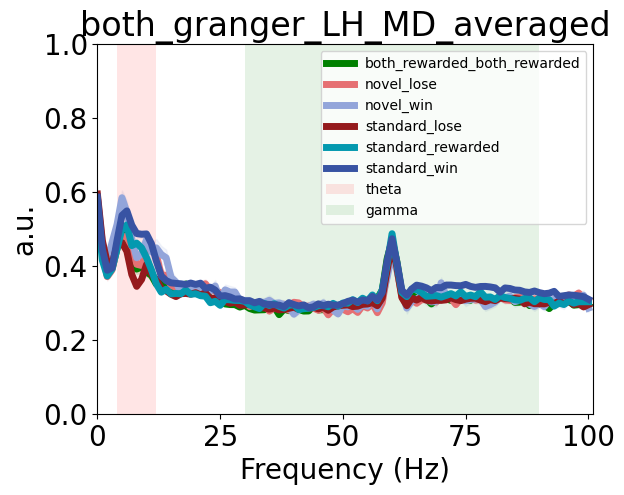

<Figure size 640x480 with 0 Axes>

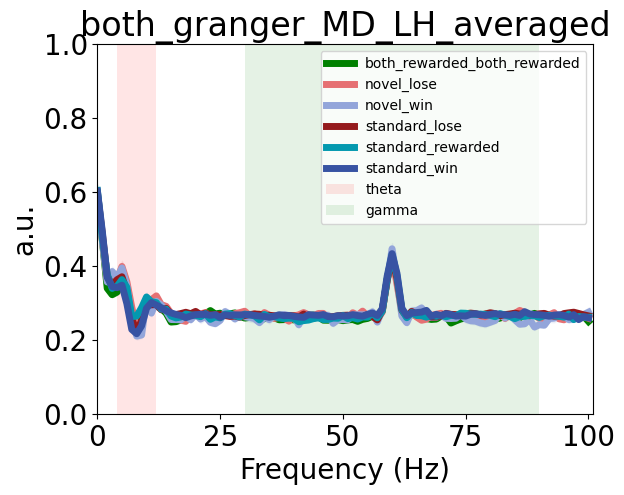

<Figure size 640x480 with 0 Axes>

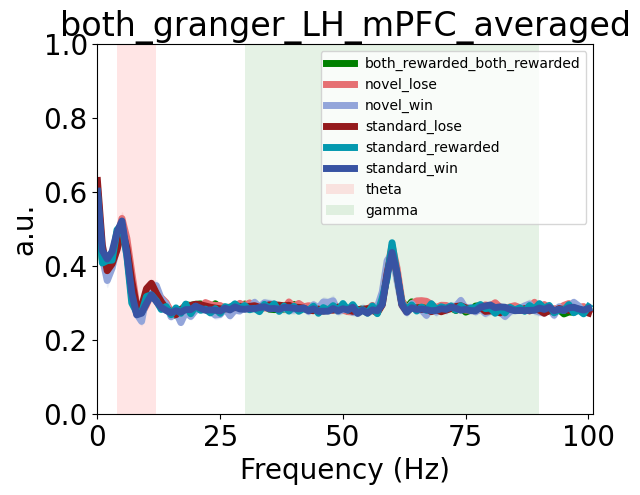

<Figure size 640x480 with 0 Axes>

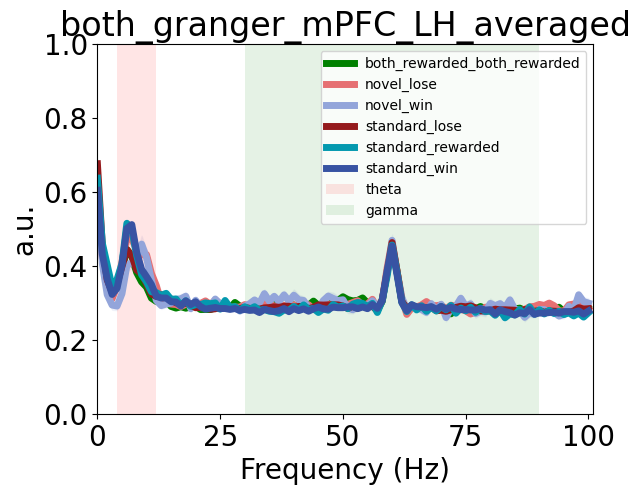

<Figure size 640x480 with 0 Axes>

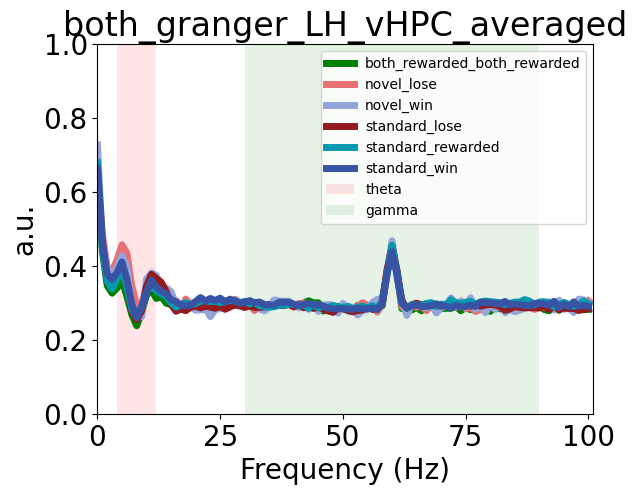

<Figure size 640x480 with 0 Axes>

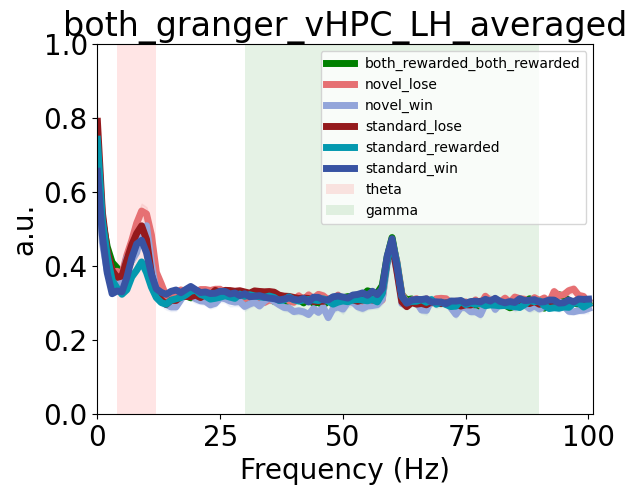

<Figure size 640x480 with 0 Axes>

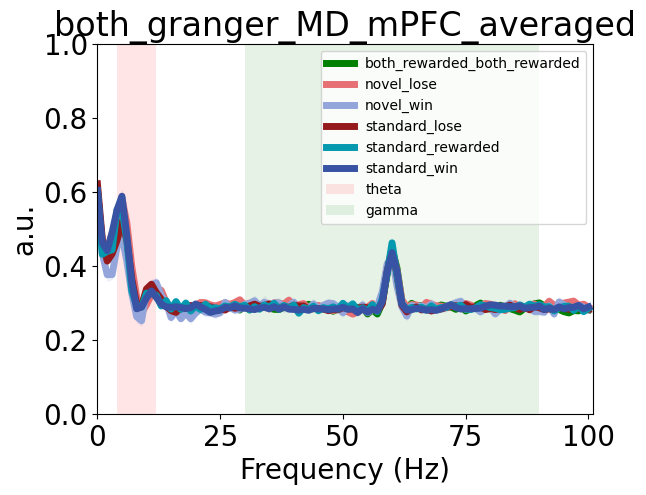

<Figure size 640x480 with 0 Axes>

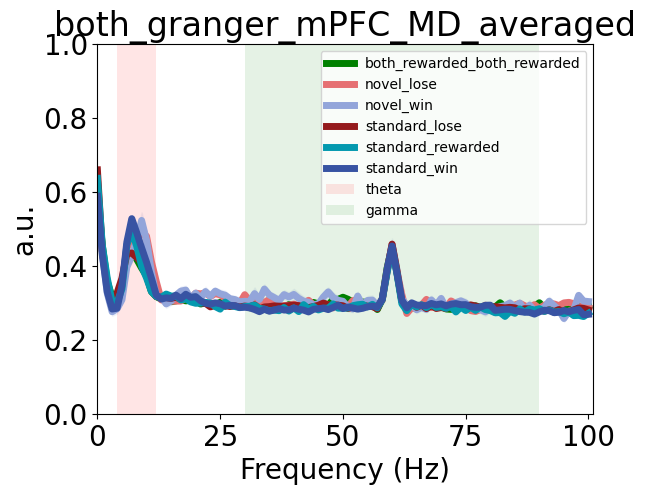

<Figure size 640x480 with 0 Axes>

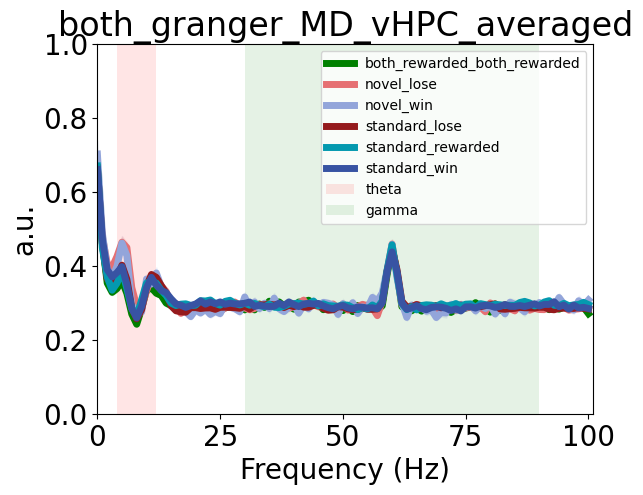

<Figure size 640x480 with 0 Axes>

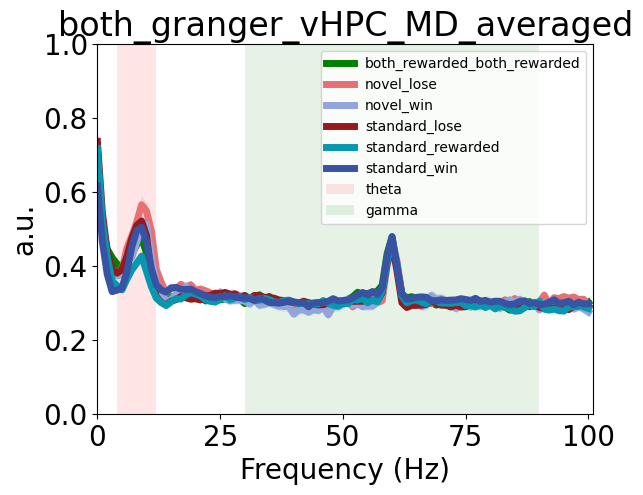

<Figure size 640x480 with 0 Axes>

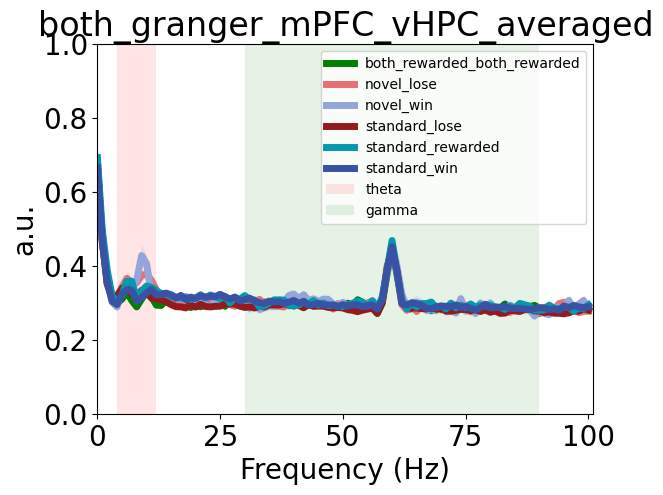

<Figure size 640x480 with 0 Axes>

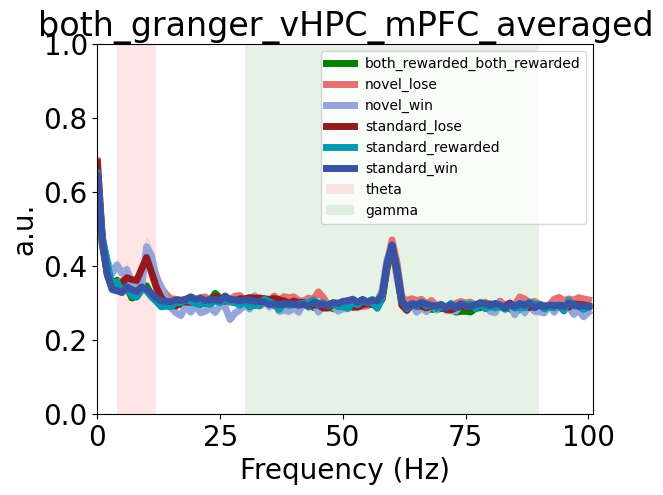

<Figure size 640x480 with 0 Axes>

In [157]:
low_freq = 0
high_freq = 101

for col in data_columns:
    fig, ax = plt.subplots()
    current_frequencies = range(low_freq, high_freq)

    plt.title("{}".format(col.split("all")[0].strip("_")))
    plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
    plt.ylabel("a.u.", fontsize=FONTSIZE)
    plt.xlim(low_freq, high_freq) 
    if "power" in col:
        plt.yscale("log")
    else:
        plt.ylim(0, 1)
    
    for index, row in grouped_all_trials_df.iterrows():   
        mean_power = np.nanmean(row[col], axis=0)
        nans, x= nan_helper(mean_power)
        mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
        sem_power = np.nanstd(row[col], axis=0) / (row[col].shape[0]**0.5)
        nans, x= nan_helper(sem_power)
        sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])        

        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(row["experiment_and_label"]), linewidth=5, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])
        except Exception as e: 
            print(e)
            pass
    # break    
    
    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    plt.legend(fontsize=10, ncol=1)
    # ax.get_legend().remove()
    plt.show()
    plt.tight_layout()
    # plt.savefig("./proc/plots/{}.png".format(col))
               

In [ ]:
TRIALS_AND_SPECTRAL_DF

In [ ]:
raise ValueError()

In [ ]:
TRIALS_AND_SPECTRAL_DF.columns

In [ ]:
TRIALS_AND_SPECTRAL_DF["power_calculation_frequencies"]

In [ ]:
raise ValueError()

### Merging LFP Trace dataframe and SLEAP pose tracking

In [ ]:
merge_columns = ["time", "recording_file", "current_subject", "video_number"]
# Find columns in df2 that are not in merge_columns and also exist in df1, then drop them from df2
cols_to_drop = [col for col in CHANNEL_MAP_AND_ALL_TRIALS_DF.columns if col not in merge_columns and col in MERGED_TRIALS_AND_VIDEO.columns]
CHANNEL_MAP_AND_ALL_TRIALS_DF = CHANNEL_MAP_AND_ALL_TRIALS_DF.drop(columns=cols_to_drop)

In [ ]:
MERGED_LFP_AND_SLEAP = pd.merge(left=CHANNEL_MAP_AND_ALL_TRIALS_DF, right=MERGED_TRIALS_AND_VIDEO, on=merge_columns, how="right")

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:
trace_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trace" in col]

In [ ]:
trial_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "trial_lfp_trace" in col])
baseline_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "baseline_lfp_trace" in col])

In [ ]:
trial_trace_columns

## Power Calcuation

- Calcuating the power at each frequency band

In [ ]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_multitaper".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_lfp_trace".format(region_and_baseline_or_trial)].apply(lambda x: Multitaper(time_series=x, sampling_frequency=RESAMPLE_RATE, time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,                                                                              time_window_duration=TIME_WINDOW_DURATION, time_window_step=TIME_WINDOW_STEP                                                                                                                                         ))

In [ ]:
for col in trace_columns:
    print(col)
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_multitaper".format(region_and_baseline_or_trial)].apply(lambda x: Connectivity.from_multitaper(x))

In [ ]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_frequencies".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)].apply(lambda x: x.frequencies)

In [ ]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_power_all-window".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)].apply(lambda x: x.power().squeeze())

In [ ]:
MERGED_LFP_AND_SLEAP["{}_power_all-window".format(region_and_baseline_or_trial)].iloc[0].shape

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "multitaper" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "connectivity" in col], errors="ignore")

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:
for col in MERGED_LFP_AND_SLEAP.columns:
    print(col)

### Averaging the power for all the windows(without any velocity parsing) 

In [ ]:
power_all_window_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "power_all-window" in col and "baseline-trial" not in col]

In [ ]:
power_all_window_columns

In [ ]:
for col in power_all_window_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    print(region_and_baseline_or_trial)
    MERGED_LFP_AND_SLEAP["{}_power_window-averaged".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.array(x[col]).mean(axis=0), axis=1)

In [ ]:
MERGED_LFP_AND_SLEAP["{}_power_window-averaged".format(region_and_baseline_or_trial)].iloc[0].shape

In [ ]:
MERGED_LFP_AND_SLEAP.drop(columns=trace_columns, errors="ignore").to_pickle("./proc/rce_lfp_all-window_power.pkl")


# Parsing by velocity

- Getting a mask for each segment based on velocity

In [ ]:
all_bins = set(x for lst in MERGED_LFP_AND_SLEAP["trial_subject_thorax_velocity_binned"] for x in lst)

In [ ]:
all_bins

In [ ]:
baseline_power_all_window_columns = [col for col in MERGED_LFP_AND_SLEAP if "baseline_power_all-window" in col and "baseline-trial" not in col]
trial_power_window_averaged_columns = [col for col in MERGED_LFP_AND_SLEAP if "trial_power_all-window" in col and "baseline-trial" not in col]

In [ ]:
baseline_power_all_window_columns

In [ ]:
MERGED_LFP_AND_SLEAP[baseline_power_all_window_columns[0]].iloc[0].shape

In [ ]:
MERGED_LFP_AND_SLEAP["baseline_subject_thorax-to-reward-port_distance_binned"]

In [ ]:
all_bin_df = []
for bin in all_bins:
    current_df = MERGED_LFP_AND_SLEAP.copy()
    current_df["baseline_velocity_binned-mask"] = current_df["baseline_subject_thorax_velocity_binned"].apply(lambda x: [index for index, num in enumerate(x) if num == bin])
    current_df["trial_velocity_binned-mask"] = current_df["trial_subject_thorax_velocity_binned"].apply(lambda x: [index for index, num in enumerate(x) if num == bin])
    
    for col in baseline_power_all_window_columns:
        region_and_baseline_or_trial = "_".join(col.split("_")[:2])
        current_df["{}_power_window-averaged-velocity-parsed".format(region_and_baseline_or_trial)] = current_df.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["baseline_velocity_binned-mask"]]), axis=0), axis=1)

    for col in trial_power_window_averaged_columns:
        region_and_baseline_or_trial = "_".join(col.split("_")[:2])
        current_df["{}_power_window-averaged-velocity-parsed".format(region_and_baseline_or_trial)] = current_df.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["trial_velocity_binned-mask"]]), axis=0), axis=1)
    
    current_df["velocity_bin"] = bin
    all_bin_df.append(current_df)
        
    
    


In [ ]:
VELOCITY_PARSED_MERGED_LFP_AND_SLEAP = pd.concat(all_bin_df).reset_index(drop=True)

## Plotting all the similar velocities together

In [ ]:
power_window_averaged_columns = [col for col in VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.columns if "power_window-averaged-velocity-parsed" in col]

- Grouping by trial outcome and velocity

In [ ]:
power_window_averaged_columns

In [ ]:
grouped_all_trials_df = VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.groupby([GROUPINGS, 'velocity_bin']).agg({k: lambda x: np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]) for k in power_window_averaged_columns}).reset_index()

In [ ]:
grouped_all_trials_df["mPFC_baseline_power_window-averaged-velocity-parsed"].iloc[1].shape

In [ ]:
grouped_all_trials_df = pd.melt(grouped_all_trials_df, id_vars =[GROUPINGS, 'velocity_bin'], value_vars =grouped_all_trials_df.drop(columns=[GROUPINGS, "velocity_bin"]).columns, value_name="power", var_name="region_and_baseline_or_trial") 

In [ ]:
grouped_all_trials_df.head()

In [ ]:
grouped_all_trials_df["brain_region"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [ ]:
grouped_all_trials_df["trial_or_baseline"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [ ]:
grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"].reset_index(drop=True)

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
grouped_all_trials_df[GROUPINGS].unique()

In [ ]:
grouped_all_trials_df

## Drawing all velocity bins together for each trial outcome

In [ ]:
grouped_all_trials_df.head()

In [ ]:
ALL_FREQUENCIES = [int(num) for num in VELOCITY_PARSED_MERGED_LFP_AND_SLEAP[[col for col in VELOCITY_PARSED_MERGED_LFP_AND_SLEAP if "frequencies" in col][0]].iloc[0]]

In [ ]:
low_freq = 0
high_freq = 13
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df[GROUPINGS].unique():
        fig, ax = plt.subplots()
        plt.title("{} during {} trials".format(region.split("_")[0], outcome), fontsize=30)
        plt.xlabel("Frequency", fontsize=20)
        plt.ylabel("Power", fontsize=20)
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.1)
        outcome_df = region_df[(region_df[GROUPINGS] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{}".format(BIN_TO_VELOCITY[row["velocity_bin"]]), linewidth=3, color=gradient_colors[-(row["velocity_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["velocity_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
                
        plt.legend()
        plt.tight_layout()
        plt.savefig("./proc/velocity_parsed_power/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

In [ ]:
low_freq = 12
high_freq = 31
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df[GROUPINGS].unique():
        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.015)
        
        outcome_df = region_df[(region_df[GROUPINGS] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{} {}".format(outcome, BIN_TO_VELOCITY[row["velocity_bin"]]), linewidth=3, color=gradient_colors[-(row["velocity_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["velocity_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
        plt.legend()
        plt.savefig("./proc/velocity_parsed_power/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

In [ ]:
low_freq = 30
high_freq = 91
for region in grouped_all_trials_df["region_and_baseline_or_trial"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["region_and_baseline_or_trial"] == region]

    for outcome in region_df[GROUPINGS].unique():
        fig, ax = plt.subplots()
        plt.title("Z-Scored LFP Power in {} for {}".format(region.split("_")[0], outcome))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(low_freq, high_freq) 
        # plt.yscale("log")
        plt.ylim(0, 0.004)
        outcome_df = region_df[(region_df[GROUPINGS] == outcome)]
        # Generate gradient colors
        gradient_colors = generate_gradient_colors(OUTCOME_TO_COLOR[outcome], 20)
        
        for index, row in outcome_df.iterrows():           
            current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
            mean_power = row["mean_power"][low_freq: high_freq]
            sem_power = row["sem_power"][low_freq: high_freq]
                
            
            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label="{} {}".format(outcome, BIN_TO_VELOCITY[row["velocity_bin"]]), linewidth=3, color=gradient_colors[-(row["velocity_bin"]+1) *4])
                
                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=gradient_colors[-(row["velocity_bin"]+1) *4])
            
            except Exception as e: 
                print(e)
                continue
        plt.legend()
        plt.savefig("./proc/velocity_parsed_power/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}_{}.png".format(low_freq, high_freq, region.split("_")[0], outcome))

# Plotting be velocity

In [ ]:
grouped_all_trials_df = VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.groupby(['velocity_bin']).agg({k: lambda x: np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]) for k in power_window_averaged_columns}).reset_index()

In [ ]:
grouped_all_trials_df = pd.melt(grouped_all_trials_df, id_vars =['velocity_bin'], value_vars =grouped_all_trials_df.drop(columns=["velocity_bin"]).columns, value_name="power", var_name="region_and_baseline_or_trial") 

In [ ]:
grouped_all_trials_df.head()

In [ ]:
grouped_all_trials_df["brain_region"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [ ]:
grouped_all_trials_df["trial_or_baseline"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
grouped_all_trials_df.head()

# Drawing all velocity bins together for each trial outcome

In [ ]:
OUTCOME_TO_COLOR

In [ ]:
grouped_all_trials_df.head()

In [ ]:
low_freq = 0
high_freq = 13
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("{} ".format(region.split("_")[0]), fontsize=30)
    plt.xlabel("Frequency", fontsize=30)
    plt.ylabel("Power", fontsize=30)
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    
    # Generate gradient colors
    gradient_colors = generate_gradient_colors("red", 20)
    
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(BIN_TO_VELOCITY[row["velocity_bin"]]), linewidth=5, color=gradient_colors[-(row["velocity_bin"]+1) *4])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=gradient_colors[-(row["velocity_bin"]+1) *4])
        
        except Exception as e: 
            print(e)
            continue
    plt.tight_layout()
    plt.legend(ncol=2)
    plt.savefig("./proc/velocity_parsed_power/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))

In [ ]:
low_freq = 12
high_freq = 31
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} ".format(region.split("_")[0]), fontsize=30)
    plt.xlabel("Frequency", fontsize=30)
    plt.ylabel("Power", fontsize=30)
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    
    # Generate gradient colors
    gradient_colors = generate_gradient_colors("red", 20)
    
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(BIN_TO_VELOCITY[row["velocity_bin"]]), linewidth=5, color=gradient_colors[-(row["velocity_bin"]+1) *4])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=gradient_colors[-(row["velocity_bin"]+1) *4])
        
        except Exception as e: 
            print(e)
            continue
    plt.legend()
    plt.savefig("./proc/velocity_parsed_power/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))

In [ ]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} ".format(region.split("_")[0]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    
    # Generate gradient colors
    gradient_colors = generate_gradient_colors("red", 20)
    
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(BIN_TO_VELOCITY[row["velocity_bin"]]), linewidth=5, color=gradient_colors[-(row["velocity_bin"]+1) *4])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=gradient_colors[-(row["velocity_bin"]+1) *4])
        
        except Exception as e: 
            print(e)
            continue
    plt.legend()
    plt.savefig("./proc/velocity_parsed_power/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))

# Parse power by lower velocity

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:

MERGED_LFP_AND_SLEAP["trial_velocity_binned-mask"] = MERGED_LFP_AND_SLEAP["trial_subject_thorax_velocity_chunked"].apply(lambda x: [index for index, num in enumerate(x) if MIN_VELOCITY <= num <= MAX_VELOCITY])

MERGED_LFP_AND_SLEAP["baseline_velocity_binned-mask"] = MERGED_LFP_AND_SLEAP["baseline_subject_thorax_velocity_chunked"].apply(lambda x: [index for index, num in enumerate(x) if MIN_VELOCITY <= num <= MAX_VELOCITY])

for col in baseline_power_all_window_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_power_window-averaged-velocity-parsed".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["baseline_velocity_binned-mask"]]), axis=0), axis=1)

for col in trial_power_window_averaged_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_power_window-averaged-velocity-parsed".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP.apply(lambda x: np.nanmean(np.array([x[col][i] for i in x["trial_velocity_binned-mask"]]), axis=0), axis=1)



In [ ]:
for col in MERGED_LFP_AND_SLEAP.columns:
    print(col)

In [ ]:
VELOCITY_PARSED_MERGED_LFP_AND_SLEAP[GROUPINGS]

In [ ]:
grouped_all_trials_df = VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({k: lambda x: np.vstack([arr for arr in x.tolist() if not np.any(np.isnan(arr))]) for k in power_window_averaged_columns}).reset_index()

In [ ]:
grouped_all_trials_df = pd.melt(grouped_all_trials_df, id_vars =[GROUPINGS], value_vars =grouped_all_trials_df.drop(columns=[GROUPINGS]).columns, value_name="power", var_name="region_and_baseline_or_trial") 

In [ ]:
grouped_all_trials_df.head()

In [ ]:
grouped_all_trials_df["brain_region"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [ ]:
grouped_all_trials_df["trial_or_baseline"] = grouped_all_trials_df["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
grouped_all_trials_df

In [ ]:
OUTCOME_TO_COLOR

In [ ]:
FONTSIZE=20

In [ ]:
font = {'weight' : 'medium',
        'size'   : 15}

matplotlib.rc('font', **font)

In [ ]:
BAND_TO_FREQ

In [ ]:
BAND_TO_FREQ_PLOT = {'theta': (6, 10), 'beta': (20, 30), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'beta': "blue", 'gamma': "green"}

BAND_TO_FREQ_PLOT = {'theta': (6, 10), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'gamma': "green"}

In [ ]:
low_freq = 0
high_freq = 51
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("Power Spectra {} ".format(region.split("_")[0]), fontsize=FONTSIZE)
    plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
    plt.ylabel("Power (a.u.)", fontsize=FONTSIZE)
    plt.xlim(low_freq, high_freq) 
    plt.yscale("log")
        
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(row[GROUPINGS]), linewidth=5, color=OUTCOME_TO_COLOR[row[GROUPINGS]])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row[GROUPINGS]])
        
        except Exception as e: 
            print(e)
            continue
    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    plt.legend(fontsize=15, ncol=2)


    plt.tight_layout()
    plt.savefig("./proc/velocity_parsed_power/power_spectra_all_conditions/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))
    plt.savefig("./proc/velocity_parsed_power/power_spectra_all_conditions/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}.eps".format(low_freq, high_freq, region.split("_")[0]))

In [ ]:
MERGED_LFP_AND_SLEAP.to_pickle("./proc/rce_sleap_and_power.pkl")

In [ ]:
for col in MERGED_LFP_AND_SLEAP:
    print(col)

# Filtering for each frequency band

In [ ]:
power_window_averaged_velocity_parsed_columns = [col for col in MERGED_LFP_AND_SLEAP if "trial_power_window-averaged-velocity-parsed" in col]

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.dropna(subset=power_window_averaged_velocity_parsed_columns).reset_index(drop=True)

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:
for power_column in [col for col in MERGED_LFP_AND_SLEAP if "trial_power_window-averaged-velocity-parsed" in col]:
    region = power_column.split("_")[0]
    
    for band, (low_freq, high_freq) in BAND_TO_FREQ.items():
        region_band_column = "{}_{}_band-power_window-averaged-velocity-parsed".format(region, band)
        MERGED_LFP_AND_SLEAP[region_band_column] = MERGED_LFP_AND_SLEAP[power_column].apply(lambda x: np.mean(x[low_freq: high_freq]))

In [ ]:
MERGED_LFP_AND_SLEAP.head()

In [ ]:
BRAIN_REGIONS = ["spike_interface_mPFC",
"spike_interface_vHPC",
"spike_interface_BLA",
"spike_interface_LH",
"spike_interface_MD"]
for column in [col for col in MERGED_LFP_AND_SLEAP if "spike_interface" in col]:
    print(column)

In [ ]:
band_power_window_averaged_velocity_parsed_columns = [col for col in MERGED_LFP_AND_SLEAP if "band-power_window-averaged-velocity-parsed" in col]

In [ ]:
band_power_window_averaged_velocity_parsed_columns

In [ ]:
region_and_band_to_mannwhitneyu = []
for col in band_power_window_averaged_velocity_parsed_columns:
    brain_region = col.split("_")[0]
    band = col.split("_")[1]
    for first_outcome, second_outcome in combinations(sorted(MERGED_LFP_AND_SLEAP[GROUPINGS].unique()), 2):
        first_outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == first_outcome]
        second_outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == second_outcome]
        statistic, p_value = mannwhitneyu(first_outcome_df[col], second_outcome_df[col], alternative='two-sided')
        region_and_band_to_mannwhitneyu.append({"brain_region": brain_region, "band": band, "trial_outcome": (first_outcome, second_outcome), "statistic": statistic, "p_value": p_value})

In [ ]:
region_and_band_to_mannwhitneyu = pd.DataFrame(region_and_band_to_mannwhitneyu)

In [ ]:
region_and_band_to_mannwhitneyu["significance"] = region_and_band_to_mannwhitneyu["p_value"].apply(lambda x: get_significance_stars_from_p_value(x))

In [ ]:
region_and_band_to_mannwhitneyu = region_and_band_to_mannwhitneyu.sort_values(["band", "brain_region", "p_value"]).reset_index(drop=True)

In [ ]:
region_and_band_to_mannwhitneyu

In [ ]:
region_and_band_to_mannwhitneyu.to_csv("./proc/velocity_parsed_power/power_region_and_band_to_mannwhitneyu.csv")

In [ ]:
raise ValueError()

In [ ]:
mean_power_df = MERGED_LFP_AND_SLEAP.groupby(GROUPINGS)[band_power_window_averaged_velocity_parsed_columns].mean()
sem_power_df = MERGED_LFP_AND_SLEAP.groupby(GROUPINGS)[band_power_window_averaged_velocity_parsed_columns].sem()


In [ ]:
sem_power_df

In [ ]:
MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == "lose"]["mPFC_theta_band-power_window-averaged-velocity-parsed"].std() / len(MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == "lose"]) ** 0.5

In [ ]:


for column in band_power_window_averaged_velocity_parsed_columns:
    fig, ax = plt.subplots(figsize=(23, 12))

    brain_region = column.split("_")[0]
    band = column.split("_")[1]
    plt.title("Power of {} {} Band".format(brain_region, band.capitalize()), fontsize=80)
    plt.ylabel("Power (a.u.)", fontsize=80)
    bars = plt.bar(mean_power_df.index, mean_power_df[column], color=mean_power_df.index.map(OUTCOME_TO_COLOR))
    
    plt.errorbar(mean_power_df.index, mean_power_df[column],
        yerr=sem_power_df[column],
        color='k',
        capsize=30,
        linestyle='None',
        elinewidth=7,
        capthick=7)
    
    plt.ylim(0, BAND_TO_YLIM[band])
    plt.xticks(fontsize=60)
    plt.yticks(fontsize=60)
    plt.locator_params(axis='y', nbins=4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig("./proc/velocity_parsed_power/bar_plots/{}_{}_velocity_parsed_lfp_power_bar.eps".format(band, brain_region)) #nancy changed png to eps
    plt.savefig("./proc/velocity_parsed_power/bar_plots/{}_{}_velocity_parsed_lfp_power_bar.png".format(band, brain_region)) #nancy changed png to eps


In [ ]:


for column in band_power_window_averaged_velocity_parsed_columns:
    fig, ax = plt.subplots(figsize=(12, 12))
    
    brain_region = column.split("_")[0]
    band = column.split("_")[1]
    plt.title("Power of {} {} Band".format(brain_region, band.capitalize()), fontsize=40)
    plt.ylabel("Power (a.u.)", fontsize=40)

    all_outcome_data = [MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == trial_outcome][column] for trial_outcome in MERGED_LFP_AND_SLEAP["trial_outcome"].unique()]
    
    bplot = ax.boxplot(all_outcome_data,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=MERGED_LFP_AND_SLEAP["trial_outcome"].unique())  # will be used to label x-ticks

    # fill with colors
    for patch, trail_outcome in zip(bplot['boxes'], MERGED_LFP_AND_SLEAP["trial_outcome"].unique()):
        patch.set_facecolor(OUTCOME_TO_COLOR[trail_outcome])

    plt.xticks(fontsize=30)
    plt.yticks(fontsize=40)
    plt.tight_layout()
    plt.savefig("./proc/velocity_parsed_power/box_plots/{}_{}_velocity_parsed_lfp_box_plot.eps".format(band, brain_region)) #nancy changed png to eps
    plt.savefig("./proc/velocity_parsed_power/box_plots/{}_{}_velocity_parsed_lfp_box_plot.png".format(band, brain_region)) #nancy changed png to eps
    
    # bars = plt.bar(mean_power_df.index, mean_power_df[column], color=mean_power_df.index.map(OUTCOME_TO_COLOR))
    
    # plt.errorbar(mean_power_df.index, mean_power_df[column],
    #     yerr=sem_power_df[column],
    #     color='k',
    #     capsize=30,
    #     linestyle='None',
    #     elinewidth=7,
    #     capthick=7)
    
    # plt.ylim(0, BAND_TO_YLIM[band])

    # plt.locator_params(axis='y', nbins=4)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)




# OLD CODE BELOW Exporting Velocity Parsed dataframe for plotting

In [ ]:
raise ValueError()

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "lfp_trace" in col], errors="ignore")

In [ ]:
MERGED_LFP_AND_SLEAP["mPFC_trial_power_window-averaged-velocity-parsed"].iloc[0].shape

In [ ]:
for col in MERGED_LFP_AND_SLEAP:
    print(col)

In [ ]:
MERGED_LFP_AND_SLEAP.to_pickle("./proc/rce_sleap_and_power.pkl")

In [ ]:
MERGED_LFP_AND_SLEAP["recording_file"].unique()

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP = VELOCITY_PARSED_MERGED_LFP_AND_SLEAP[VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["velocity_bin"] == 0].copy()

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP = EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.drop(columns=[col for col in EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.columns if "baseline" in col], errors="ignore")

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP = EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.drop(columns=[col for col in EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.columns if "trace" in col], errors="ignore")

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP = pd.melt(EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP, id_vars=EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.columns[:19], value_vars=[col for col in EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.columns if "power_window-averaged-velocity-parsed" in col], value_name="power", var_name="region_and_baseline_or_trial")




In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["brain_region"] = EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["region_and_baseline_or_trial"].apply(lambda x:x.split("_")[0])
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["trial_or_baseline"] = EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["region_and_baseline_or_trial"].apply(lambda x:x.split("_")[1])

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP = EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.dropna(subset=["power"])

In [ ]:
for band, (min_freq, max_freq) in BAND_TO_FREQ.items():
    EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["mean_{}_power".format(band)] = EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP["power"].apply(lambda x: np.nanmean(x[min_freq:max_freq]))

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.to_pickle("./proc/rce_velocity_parsed_power_spectra_region_and_baselinetrial_rows.pkl")

In [ ]:
EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP

In [ ]:
for col in EXPORTED_VELOCITY_PARSED_MERGED_LFP_AND_SLEAP.columns[:19]:
    print(col)

# Calculating the velocity parsed average power for each frequency band

In [ ]:
BAND_TO_FREQ

In [ ]:
velocity_parsed_power_window_averaged_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "power_window-averaged-velocity-parsed" in col]

In [ ]:
velocity_parsed_power_window_averaged_columns

- Removing all trials that have a high velocity trhoguhout

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_velocity_binned-mask"].map(len) >= 1]

In [ ]:
for col in velocity_parsed_power_window_averaged_columns:
    region_base_name = "_".join(col.split("_")[:2])
    print(region_base_name)
    for band, (min_freq, max_freq) in BAND_TO_FREQ.items():
        print(band)
        MERGED_LFP_AND_SLEAP["{}_{}_all_power".format(region_base_name, band)] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: x[min_freq:max_freq])
        MERGED_LFP_AND_SLEAP["{}_{}_mean_power".format(region_base_name, band)] = MERGED_LFP_AND_SLEAP["{}_{}_all_power".format(region_base_name, band)].apply(lambda x: x.mean())

In [ ]:
# MD_trial_mean_gamma_power
mean_power_col = [col for col in MERGED_LFP_AND_SLEAP.columns if "mean_power" in col]

In [ ]:
mean_power_df = pd.DataFrame(MERGED_LFP_AND_SLEAP.groupby([GROUPINGS])[mean_power_col].mean()).reset_index()

In [ ]:
mean_power_df["color"] = mean_power_df[GROUPINGS].map(OUTCOME_TO_COLOR)

In [ ]:
sem_power_df = pd.DataFrame(MERGED_LFP_AND_SLEAP.groupby([GROUPINGS])[mean_power_col].sem()).reset_index()

In [ ]:
mean_power_df

In [ ]:
OUTCOME_COMPARISONS

In [ ]:
rank_sum_dict = []
for col in mean_power_col:
    region = col.split("_")[0]
    baseline_or_trial = col.split("_")[1]
    band = col.split("_")[2]
    if baseline_or_trial != "trial":
        continue
    for key, (first_outcome, second_outcome) in  OUTCOME_COMPARISONS.items():
        first_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == first_outcome]
        second_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == second_outcome]
        statistic, p_value = mannwhitneyu(first_df[col], second_df[col], alternative='two-sided')
        rank_sum_dict.append({"region": region, "band": band, "comparison": key, "mannwhitneyu_statistic": statistic, "mannwhitneyu_pvalue": p_value, "all_outcomes": set([first_outcome, second_outcome])})
rank_sum_df = pd.DataFrame(rank_sum_dict)

In [ ]:
rank_sum_df.head()

In [ ]:
current_df

In [ ]:
round(mean_power_df[[col for col in mean_power_df.columns if "theta" in col]].to_numpy().max() * 1.25, 3)

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.copy()
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "multitaper" in col], errors="ignore").copy()
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "connectivity" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "frequencies" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "spike_interface" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "power_window-averaged-velocity-parsed" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "all-window_power" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "all_power" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "window-averaged_power" in col], errors="ignore")

